# This file makes figures for the INDVOL paper.

In [2]:
# Import libraries

import numpy as np
import pandas as pd
from scipy import stats
from collections import Counter
import json
from functools import reduce
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy.stats import linregress

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
sns.set('talk')

_____________________

# 0. Helper functions

In [3]:
# this function runs a t-test
def compare_ttest(sample1,sample2):
    t_values, p_values = stats.ttest_ind(sample1.T, sample2.T)
    return t_values, p_values

# this function runs two chi-squared tests to compare distributions 'u' and 'v' and averages them
def symmetrised_chi_square(u,v):
    chisq1, p_value1 = stats.chisquare(f_obs=u, f_exp=v_exp)
    chisq2, p_value2 = stats.chisquare(f_obs=v, f_exp=u_exp)           
    return np.mean([p_value1, p_value2])

# this function runs chi-squared tests comparing two dataframes
def compare_symmetric_chi2(df1, df2):
    chi2s = []
    
    for col in df1.columns:
        u = df1[col]
        v = df2[col]

        u[u==0] = 1
        v[v==0] = 1

        u_exp = u/u.sum() * sum(v)
        v_exp = v/v.sum() * sum(u)
        
        chisq1, p_value1 = stats.chisquare(f_obs=u, f_exp=v_exp)
        chisq2, p_value2 = stats.chisquare(f_obs=v, f_exp=u_exp)        
        
        out_p_value = np.mean([p_value1, p_value2])
        chi2s += [ out_p_value ]
    return chi2s

# this function runs chi squared values on a pair of columns and takes the largest (most conservative) value
def compare_symmetric_chi2_single_col(u, v):
    u_exp = u/u.sum() * sum(v)
    v_exp = v/v.sum() * sum(u)

    chisq1, p_value1 = stats.chisquare(f_obs=u, f_exp=v_exp)
    chisq2, p_value2 = stats.chisquare(f_obs=v, f_exp=u_exp)        

    out_p_value = max([p_value1, p_value2])
    chi2s       = out_p_value
    return chi2s

In [4]:
# To remove outliers:
# 1 - Estimate median
# 2 - Estimate median deviation from the median
# 3 - Exclude people who deviate more than (3 deviations from the median)*M, where M represents the pop size

def remove_outliers(series):
    absolute_deviation_from_median = np.abs(series - series.median())
    M = len(series) # number of measurements

    b   = 1.4826
    MAD = b * absolute_deviation_from_median.median()

    outliers = absolute_deviation_from_median > 3*MAD
    series_without_outliers = series[~outliers]

    return series_without_outliers

In [5]:
issues = ['Human rights', 'Climate change', 'Immigration', 'Hate speech', 'Social inequality',
          'Fake news', "Women's rights", 'LGBTQ  rights', 'EU membership', 'COVID-19']

_________________

# 1. Load data and transform it into the format we'll need for analysis

In [6]:
questions2tags = {
 'The government should be doing more to tackle climate change.':'Climate change',
 'More should be done to ensure women have equal rights to men.':"Women's rights",
 'It is important to ensure LGBTQ  people have the same rights as other members of society.':'LGBTQ  rights',
 'Social media websites should not display fake news stories.':'Fake news',
 'The government should reduce the level of immigration into Britain.':'Immigration',
 'The government should do more to protect human rights regardless of race, religion etc.':'Human rights',
 'I would support action to tackle online hate speech.':'Hate speech',
 'The government should take more steps to reduce social inequality.':'Social inequality',
 'Leaving the EU will be positive for the United Kingdom.':'EU membership',
 'During the COVID-19 crisis, the government should prioritise saving lives over protecting the economy.':'COVID-19'
}

In [7]:
# Load data
df_to_be_analysed = pd.read_csv('INDVOL_data_two_waves.tsv', sep='\t')

df_to_be_analysed.head()

,userid,issue,wave,score,ranking,reaction_time_ms,finaltime,socinfo
0,5cb4b1cc96d87400010836bd,Human rights,wave1,0.977205,1,4199,"03 Sep 2020, 12:25:10",0.0
1,5cb4b1cc96d87400010836bd,Climate change,wave1,0.977205,4,2481,"03 Sep 2020, 12:25:10",0.0
2,5cb4b1cc96d87400010836bd,Immigration,wave1,0.977205,2,2797,"03 Sep 2020, 12:25:10",0.0
3,5cb4b1cc96d87400010836bd,Hate speech,wave1,0.655063,6,3380,"03 Sep 2020, 12:25:10",0.0
4,5cb4b1cc96d87400010836bd,Social inequality,wave1,0.658228,9,4580,"03 Sep 2020, 12:25:10",0.0


## 1.1 Define some helper variables

In [8]:
df = df_to_be_analysed

In [9]:
users_wave2 = df[df.wave.isin(['wave2_control','wave2_treatment'])].userid.unique()

d_H10 = df[ df.userid.isin(users_wave2) & (df.issue.isin(issues)) ]

In [10]:
user_opinions = {}

for _, row in d_H10.iterrows():
    userid  = row['userid']
    wave    = row['wave']
    score   = row['score']
    issue   = row['issue']
    ranking = row['ranking']
    socinfo = row['socinfo']
    
    if userid not in user_opinions:
        user_opinions[userid] = {}

    if issue not in user_opinions[userid]:
        user_opinions[userid][issue] = { 'score':{}, 'ranking':{} }
    
    user_opinions[userid][issue]['socinfo']       = socinfo
    user_opinions[userid][issue]['score'][wave]   = score
    user_opinions[userid][issue]['ranking'][wave] = ranking

In [11]:
tuples = []

for userid in user_opinions:
    for issue in user_opinions[userid]:
        if (len(user_opinions[userid][issue]['score']) == 2):

            w1_score   = user_opinions[userid][issue]['score']['wave1']
            w1_ranking = user_opinions[userid][issue]['ranking']['wave1']
            soc_info   = user_opinions[userid][issue]['socinfo']
            try:
                delta_score = user_opinions[userid][issue]['score']['wave2_control']     - w1_score
                delta_ranking = user_opinions[userid][issue]['ranking']['wave2_control'] - w1_ranking                
                group = 'control'
            except:
                delta_score = user_opinions[userid][issue]['score']['wave2_treatment']     - w1_score
                delta_ranking = user_opinions[userid][issue]['ranking']['wave2_treatment'] - w1_ranking
                group = 'treatment'
                
            tuples += [ (userid, group, issue, delta_score, delta_ranking, soc_info, w1_score, w1_ranking) ]
            
df_deltas = pd.DataFrame(tuples, columns=['userid','group','issue','delta_score','delta_ranking','soc_info', 'w1_score', 'w1_ranking'])

In [12]:
df_deltas_treatment = df_deltas[df_deltas.group=='treatment']
df_deltas_control   = df_deltas[df_deltas.group=='control']

In [13]:
personality_scores = {}

userids = df[df.wave=='wave1'].userid.unique()

for userid in userids:
    d = df[ (df.userid==userid) & (df.wave=='wave1') ]
    
    try:

        q1 = d[d.issue=='I see myself as sympathetic, warm.'].iloc[0]['score']
        q2 = d[d.issue=='I see myself as critical, quarrelsome.'].iloc[0]['score']
        agreeableness = np.mean([q1,1-q2])

        q1 = d[d.issue=='I see myself as open to new experiences, complex.'].iloc[0]['score']
        q2 = d[d.issue=='I see myself as conventional, uncreative.'].iloc[0]['score']
        openness = np.mean([q1,1-q2])

        q1 = d[d.issue=='I see myself as dependable, self-disciplined.'].iloc[0]['score']
        q2 = d[d.issue=='I see myself as disorganized, careless.'].iloc[0]['score']
        conscientiousness = np.mean([q1,1-q2])

        q1 = d[d.issue=='I see myself as extraverted, enthusiastic.'].iloc[0]['score']
        q2 = d[d.issue=='I see myself as reserved, quiet.'].iloc[0]['score']
        extraversion = np.mean([q1,1-q2])
        
        q1 = d[d.issue=='I see myself as anxious, easily upset.'].iloc[0]['score']
        q2 = d[d.issue=='I see myself as calm, emotionally stable.'].iloc[0]['score']
        neuroticism = np.mean([q1,1-q2])
    
        personality_scores[userid] = [agreeableness, openness, conscientiousness, extraversion, neuroticism]

    except IndexError:
        continue

In [14]:
users_wave2 = df[df.wave.isin(['wave2_control','wave2_treatment'])].userid.unique()

df_op_change = df[ df.userid.isin(users_wave2) & (df.issue.isin(issues)) ]

_________________________
# 2. Main figures

##  Fig 1: Opinion distributions

In [15]:
bins_opinion = np.linspace(-.75,.75,16)

print(bins_opinion)

[-0.75 -0.65 -0.55 -0.45 -0.35 -0.25 -0.15 -0.05  0.05  0.15  0.25  0.35
  0.45  0.55  0.65  0.75]


In [16]:
bins_ranking = np.arange(-8.5,8.5,1)

print(bins_ranking)

[-8.5 -7.5 -6.5 -5.5 -4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5
  5.5  6.5  7.5]


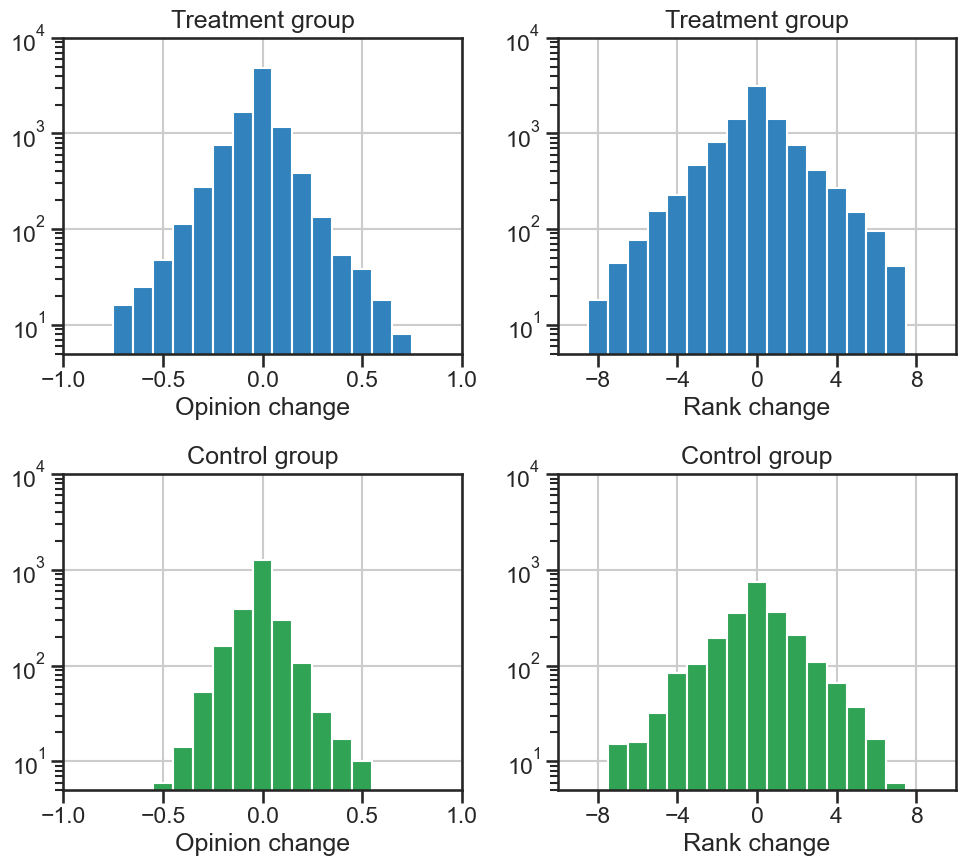

In [17]:
sns.set('talk')
sns.set_style('ticks')
import matplotlib.colors

pad  = 7
colors = [plt.cm.tab20c(0),plt.cm.tab20c(2),plt.cm.tab20c(8),plt.cm.tab20c(10)]
colors = [plt.cm.tab20c(0),plt.cm.tab20c(0),plt.cm.tab20c(8),plt.cm.tab20c(8)]

delta_column = 'delta_score'

fig, axs = plt.subplots(2,2,figsize=(10,9))
axs = axs.T.flatten()

ax = axs[0]
df_deltas_treatment[delta_column].hist(bins=bins_opinion, ax=ax, color=colors[0])
ax.set_title(r'Treatment group', pad=pad)

ax = axs[1]
df_deltas_control[delta_column].hist(bins=bins_opinion, ax=ax, color=colors[2])
ax.set_title('Control group', pad=pad)

for ax in axs[:2]:
    ax.set_xlim(-.8,.8)
    ax.set_ylim(5,10000)
    ax.set_xlabel('Opinion change')
    ax.set_xticks(np.arange(-1,1.5,.5))
    ax.set_yscale('log')


delta_column = 'delta_ranking'

ax = axs[2]
df_deltas_treatment[delta_column].hist(bins=bins_ranking, ax=ax, color=colors[1])
ax.set_title('Treatment group', pad=pad)

ax = axs[3]
df_deltas_control[delta_column].hist(bins=bins_ranking, ax=ax, color=colors[3])
ax.set_title('Control group', pad=pad)

for ax in axs[2:]:
    ax.set_xlim(-10,10)
    ax.set_ylim(5,10000)
    ax.set_xlabel('Rank change')
    ax.set_xticks(np.arange(-8,10,4))
    ax.set_yscale('log')   
    
plt.tight_layout()
plt.savefig('images/Fig-distributions-with-outliers.png')
plt.show()

# If we want to add text to the figures, here's some sample code
# ax.text(-8, 600, "D.", fontsize=20, weight="bold", bbox=dict(facecolor='w', alpha=1.0))

## SI: make the same figure, but removing outliers

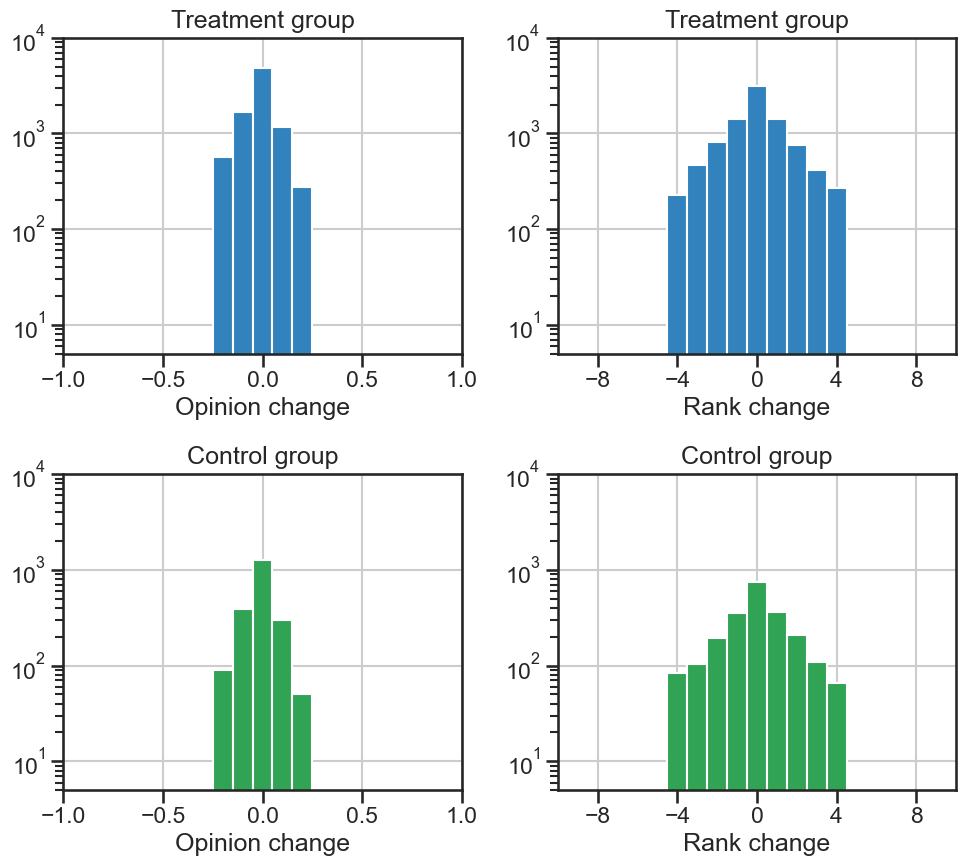

In [18]:
sns.set('talk')
sns.set_style('ticks')
import matplotlib.colors

pad  = 7
colors = [plt.cm.tab20c(0),plt.cm.tab20c(2),plt.cm.tab20c(8),plt.cm.tab20c(10)]
colors = [plt.cm.tab20c(0),plt.cm.tab20c(0),plt.cm.tab20c(8),plt.cm.tab20c(8)]

delta_column = 'delta_score'

fig, axs = plt.subplots(2,2,figsize=(10,9))
axs = axs.T.flatten()

ax = axs[0]
remove_outliers(df_deltas_treatment[delta_column]).hist(bins=bins_opinion, ax=ax, color=colors[0])
ax.set_title(r'Treatment group', pad=pad)

ax = axs[1]
remove_outliers(df_deltas_control[delta_column]).hist(bins=bins_opinion, ax=ax, color=colors[2])
ax.set_title('Control group', pad=pad)

for ax in axs[:2]:
    ax.set_xlim(-.8,.8)
    ax.set_ylim(5,10000)
    ax.set_xlabel('Opinion change')
    ax.set_xticks(np.arange(-1,1.5,.5))
    ax.set_yscale('log')


delta_column = 'delta_ranking'

ax = axs[2]
remove_outliers(df_deltas_treatment[delta_column]).hist(bins=bins_ranking, ax=ax, color=colors[1])
ax.set_title('Treatment group', pad=pad)

ax = axs[3]
remove_outliers(df_deltas_control[delta_column]).hist(bins=bins_ranking, ax=ax, color=colors[3])
ax.set_title('Control group', pad=pad)

for ax in axs[2:]:
    ax.set_xlim(-10,10)
    ax.set_ylim(5,10000)
    ax.set_xlabel('Rank change')
    ax.set_xticks(np.arange(-8,10,4))
    ax.set_yscale('log')   
    
plt.tight_layout()
plt.savefig('images/Fig-distributions-without-outliers.png')
plt.show()

________________________________________________

# Fig 3 - Contrarians

First, prepare the data for the figure:

In [19]:
df = df_deltas_treatment

In [20]:
slopes = []
userids = sorted(df.userid.unique())
for userid in userids:
    d = df[df.userid==userid]
    y = d.delta_score
    x = d.soc_info
    slope, intercept = np.polyfit(x,y,1)
    slopes += [slope]
slopes = np.array(slopes)

In [21]:
from scipy.stats import kurtosis
print('Slopes:')
print('mean:      {:.3f}'.format(np.mean(slopes)))
print('std:       {:.3f}'.format(np.std(slopes)))
print('kurtosis: {:.3f}'.format(kurtosis(slopes)))

Slopes:
mean:      0.076
std:       0.396
kurtosis: 15.157


### Prepare data on attitude vectors for PCA:

In [22]:
userids = sorted(df.userid.unique())

datapoints = []
for userid in userids:
    datapoint = df[df.userid==userid].sort_values('issue')['w1_score'].values
    datapoints += [ datapoint ] 
    
datapoints = np.array(datapoints)

print(datapoints.shape)

(957, 10)


### Run PCA:

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = datapoints
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

In [24]:
userids = sorted(df_deltas_treatment.userid.unique())

datapoints = []
for userid in userids:
    datapoint = df[df.userid==userid].sort_values('issue')['w1_score'].values
    datapoints += [ datapoint ] 
    
X = np.array(datapoints)
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_r = pca.fit(X_scaled).transform(X_scaled)

### Pick two users for the example on subplot A:

In [25]:
userid_pos_corr = '5f18362e7f876d064235cd4d'
userid_neg_corr = '5eb87f52d249ac7d7d99aabd'

In [26]:
userid = userid_pos_corr
d = df[df.userid==userid]
z = d.w1_score + d.delta_score

idx = 6572
print(d.loc[idx][['w1_score','soc_info','delta_score']])
print(z[idx])

# Result
# op1      = 0.12
# soc_info = 0.68
# op2      = 0.64

w1_score       0.124658
soc_info           0.68
delta_score    0.518432
Name: 6572, dtype: object
0.6430897485997134


In [27]:
userid = userid_neg_corr
d = df[df.userid==userid]
z = d.w1_score + d.delta_score

idx = 11408
print(d.loc[idx][['w1_score','soc_info','delta_score']])
print(z[idx])

# Result
# op1      = 0.10
# soc_info = 0.40
# op2      = -0.01

w1_score       0.103334
soc_info            0.4
delta_score   -0.010218
Name: 11408, dtype: object
0.093115340401073


In [28]:
circleA = {'op1':0.12, 'soc_info':0.68 ,'op2':0.64}
circleB = {'op1':0.10, 'soc_info':0.40 ,'op2':0.093}

for c in [circleA,circleB]:
    c['x'] = c['soc_info']
    c['y'] = c['op2']-c['op1']

In [29]:
import statsmodels.api as sm

userids = sorted(df.userid.unique())
pvalues = []

for userid in userids:
    d = df[df.userid==userid]
    y = d.delta_score
    x = d.soc_info

    # include constant in ols models, which is not done by default
    X_fit = sm.add_constant(x)
    model = sm.OLS(y,X)
    results = model.fit()
    pvalue = results.pvalues[1]
    pvalues.append(pvalue)

ValueError: endog and exog matrices are different sizes

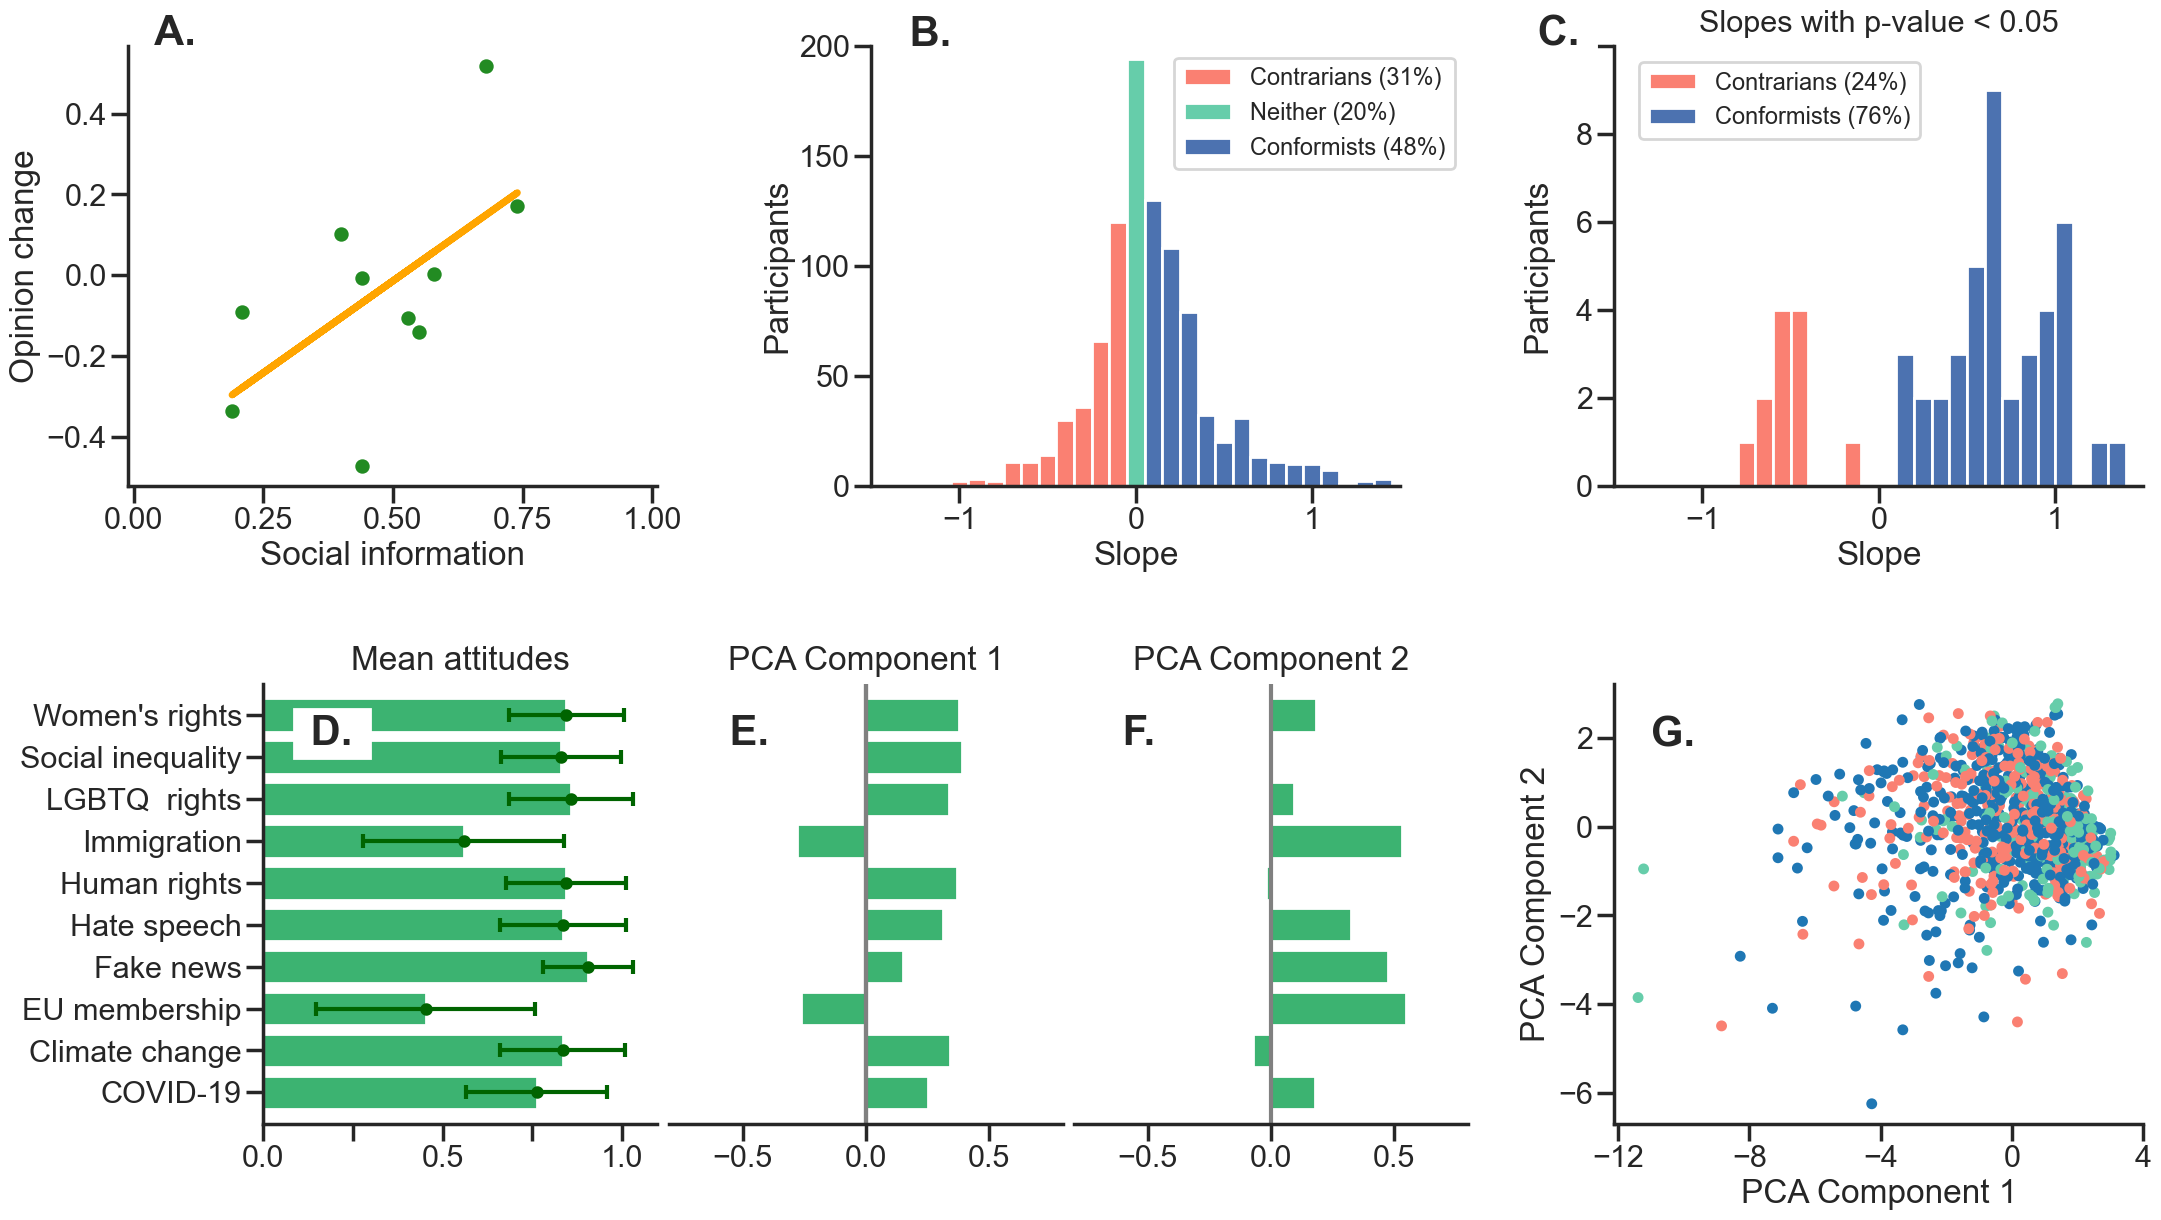

In [ ]:
#--------------------------------------------#
#                                            #
#               Prepare plots                #
#                                            #
#--------------------------------------------#

sns.set_style('ticks')
sns.set_context('poster')

fig3 = plt.figure(constrained_layout=False, figsize=(26,14))

gs = fig3.add_gridspec(2,30, hspace=0.45)

ax00 = fig3.add_subplot(gs[0, 0:8])
ax01 = fig3.add_subplot(gs[0, 11:19])
ax02 = fig3.add_subplot(gs[0, 22:30])

ax10 = fig3.add_subplot(gs[1, 2:8])
ax11 = fig3.add_subplot(gs[1, 8:14])
ax12 = fig3.add_subplot(gs[1, 14:20])
ax13 = fig3.add_subplot(gs[1, 22:30])


all_axs = [ax00, ax01, ax02, ax10, ax11, ax12, ax13]

#--------------------------------------------#
#                                            #
#        Subplot A: individual subject       #
#                                            #
#--------------------------------------------#

axs = [ax00]
userid_pos_corr = '5f18362e7f876d064235cd4d'
textA = { 'x':0.02, 'y':0.57 }
#userid_neg_corr = '5988bead492e910001deefd8'
#textB = { 'x':0.05, 'y':0.12 }

for ax,userid in zip(axs,[userid_pos_corr]):
    d = df[df.userid==userid]
    y = d.delta_score
    x = d.soc_info
    coefs = np.polyfit(x,y,1)    
    
    ax.plot(x,coefs[0]*x+coefs[1],'-', c='orange',lw=5, zorder=-1)
    ax.scatter(x,y,zorder=1, c='forestgreen', s=70)
    
    ax.set_xlabel('Social information')
    ax.set_xlim(-0.01,1.01)
    
    # Remove this later
    #ax.set_title(f'User {userid[:4]}...')

ax00.set_ylabel('Opinion change')
 
ax00.text(textA['x'], textA['y'], " A. ", fontsize=30, weight="bold",  bbox=dict(facecolor='w', alpha=1.0))

#--------------------------------------------#
#                                            #
#     Subplot B: histogram of all slopes     #
#                                            #
#--------------------------------------------#

slope_threshold = 0.05
threshold_1 = -slope_threshold
threshold_2 = slope_threshold

nbins = 2

mask1 = (slopes<threshold_1)
mask2 = (slopes>threshold_2)
mask3 = ~(mask1) & ~(mask2)

bins3 = np.linspace(threshold_1, threshold_2, nbins)
binwidth = np.diff(bins3)[0]
bins1 = np.arange(threshold_1, -1.5, -1*binwidth)[::-1]
bins2 = np.arange(threshold_2, 1.5,  binwidth)


percentage_left   = "{0:.0%}".format(sum(mask1)/len(slopes))
percentage_right  = "{0:.0%}".format(sum(mask2)/len(slopes))
percentage_centre = "{0:.0%}".format(sum(mask3)/len(slopes))

# include constant in ols models, w
label_contrarians = f'Contrarians ({percentage_left})'
label_conformists = f'Conformists ({percentage_right})'
label_centre      = f'Neither ({percentage_centre})'

ax = ax01

ax.hist(slopes[mask1],  bins=bins1, color='salmon', label=label_contrarians)
ax.hist(slopes[mask3],  bins=bins3, color='mediumaquamarine', label=label_centre)
ax.hist(slopes[mask2],  bins=bins2, label=label_conformists)

ax.set_xlabel('Slope')
ax.set_ylabel('Participants')
ax.set_xlim(-1.5,1.5)
ax.set_ylim(0,200)
#ax.set_title(f'"Neither": |slope|<{slope_threshold:.2f}', pad=10)
ax.legend(fontsize=17, bbox_to_anchor=(0.55, 1.0))

ax01.text(-1.35, 200, " B. ", fontsize=30, weight="bold",  bbox=dict(facecolor='w', alpha=1.0))


#---------------------------------------------------#
#                                                   #
#     Subplot C: histogram of significant slopes    #
#                                                   #
#---------------------------------------------------#

p_value_threshold = 0.05

significant_slopes = np.array([ s for s,p in zip(slopes, pvalues) if p<p_value_threshold])

mask1 = (significant_slopes<0)
mask2 = (significant_slopes>=0)
bins  = np.arange(-1.5, 1.5,  binwidth)

percentage_left   = "{0:.0%}".format(sum(mask1)/len(significant_slopes))
percentage_right  = "{0:.0%}".format(sum(mask2)/len(significant_slopes))

#label_contrarians = f'Contrarians ({percentage_left} or {sum(mask1)}/{len(mask1)})'
#label_conformists = f'Conformists ({percentage_right} or {sum(mask2)}/{len(mask2)})'
label_contrarians = f'Contrarians ({percentage_left})'
label_conformists = f'Conformists ({percentage_right})'


ax = ax02

ax.hist(significant_slopes[mask1],  bins=bins, color='salmon', label=label_contrarians)
ax.hist(significant_slopes[mask2],  bins=bins, label=label_conformists)

ax.set_xlabel('Slope')
ax.set_ylabel('Participants')
ax.set_ylim(0,10)
ax.set_xlim(-1.5,1.5)
ax.set_xticks([-1, 0, 1])

ax.set_title(f'Slopes with p-value < {p_value_threshold:.2f}', fontsize=22, pad=10)
#ax.legend(loc=2, fontsize=16)
ax.legend(fontsize=17, bbox_to_anchor=(0.6, 0.99))
ax.text(-2.00, 10, " C. ", fontsize=30, weight="bold",  bbox=dict(facecolor='w', alpha=1.0))

#--------------------------------------------#
#                                            #
#      Subplots D, E, F: PCA bar charts      #
#                                            #
#--------------------------------------------#

y = range(10)
ylim = [min(y)-0.75, max(y)+0.75]
xlim = [-.8,.8]
yticklabels = sorted(issues)

axs = [ax10,ax11,ax12]
for ax in axs:
    ax.plot([0,0],ylim, '-', c='grey')
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_yticks(y)    
    
# Subplot D

ax = axs[0]
ax.set_title('Mean attitudes',pad=10)
X = np.array(datapoints)
x = X.mean(axis=0)
ax.barh(y,x, color='mediumseagreen')
ax.set_yticklabels(yticklabels)
ax.errorbar(x,y,xerr=X.std(axis=0), fmt='.',c='darkgreen', solid_capstyle='projecting', capsize=5, mew=3, lw=3)
ax.set_xlim(0.0,1.1)
ax.set_xticks([0,.25,.5,.75,1])
ax.set_xticklabels(['0.0','','0.5','','1.0'])
ax.yaxis.set_ticks_position('none')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(0.1, 8.3, " D. ", fontsize=30, weight="bold",  bbox=dict(facecolor='w', alpha=1.0))

# Subplot E

ax = axs[1]
ax.set_title('PCA Component 1',pad=10)
x = pca.components_[0,:]
ax.barh(y,-x, color='mediumseagreen')
ax.plot([0,0],ylim, '-', c='grey')
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.60, 8.3, " E. ", fontsize=30, weight="bold",  bbox=dict(facecolor='w', alpha=1.0))

# Subplot F

ax = axs[2]
ax.set_title('PCA Component 2',pad=10)
x = pca.components_[1,:]
ax.barh(y,-x, color='mediumseagreen')
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.65, 8.3, " F. ", fontsize=30, weight="bold",  bbox=dict(facecolor='w', alpha=1.0))

#--------------------------------------------#
#                                            #
#          Subplot G: PCA scatter plot       #
#                                            #
#--------------------------------------------#

ax = ax13

userids = np.array(sorted(df_deltas_treatment.userid.unique()))
mask1 = (slopes<threshold_1)
mask2 = (slopes>threshold_2)
mask3 = ~(mask1) & ~(mask2)
contrarians  = userids[mask1]
centrists    = userids[mask3]
conformists  = userids[mask2]


significant_slopes = np.array([ True if p<p_value_threshold else False for s,p in zip(slopes, pvalues) ])
significant_users = userids[(significant_slopes)]

colors = []
for u in userids:
#    if u in significant_users = userids[(significant_slopes)]:
#        colors.append('gold')
    if u in centrists:
        colors.append('mediumaquamarine')
    elif u in contrarians:
        colors.append('salmon')
    else:
        colors.append( '#1f77b4')

ax.scatter(-X_r[:,0], -X_r[:,1], s=34, c=colors)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_xticks(np.arange(-12,8,4))
ax.text(-11, 1.8, "G.", fontsize=30, weight="bold")

for ax in all_axs:
    # Hide the right and top spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
plt.savefig('images/Fig-contrarians.png', dpi=150, bbox_inches='tight')
plt.show()

___________________________________________________

# 3. Other SI Figures

## SI - Opinion distributions per issue

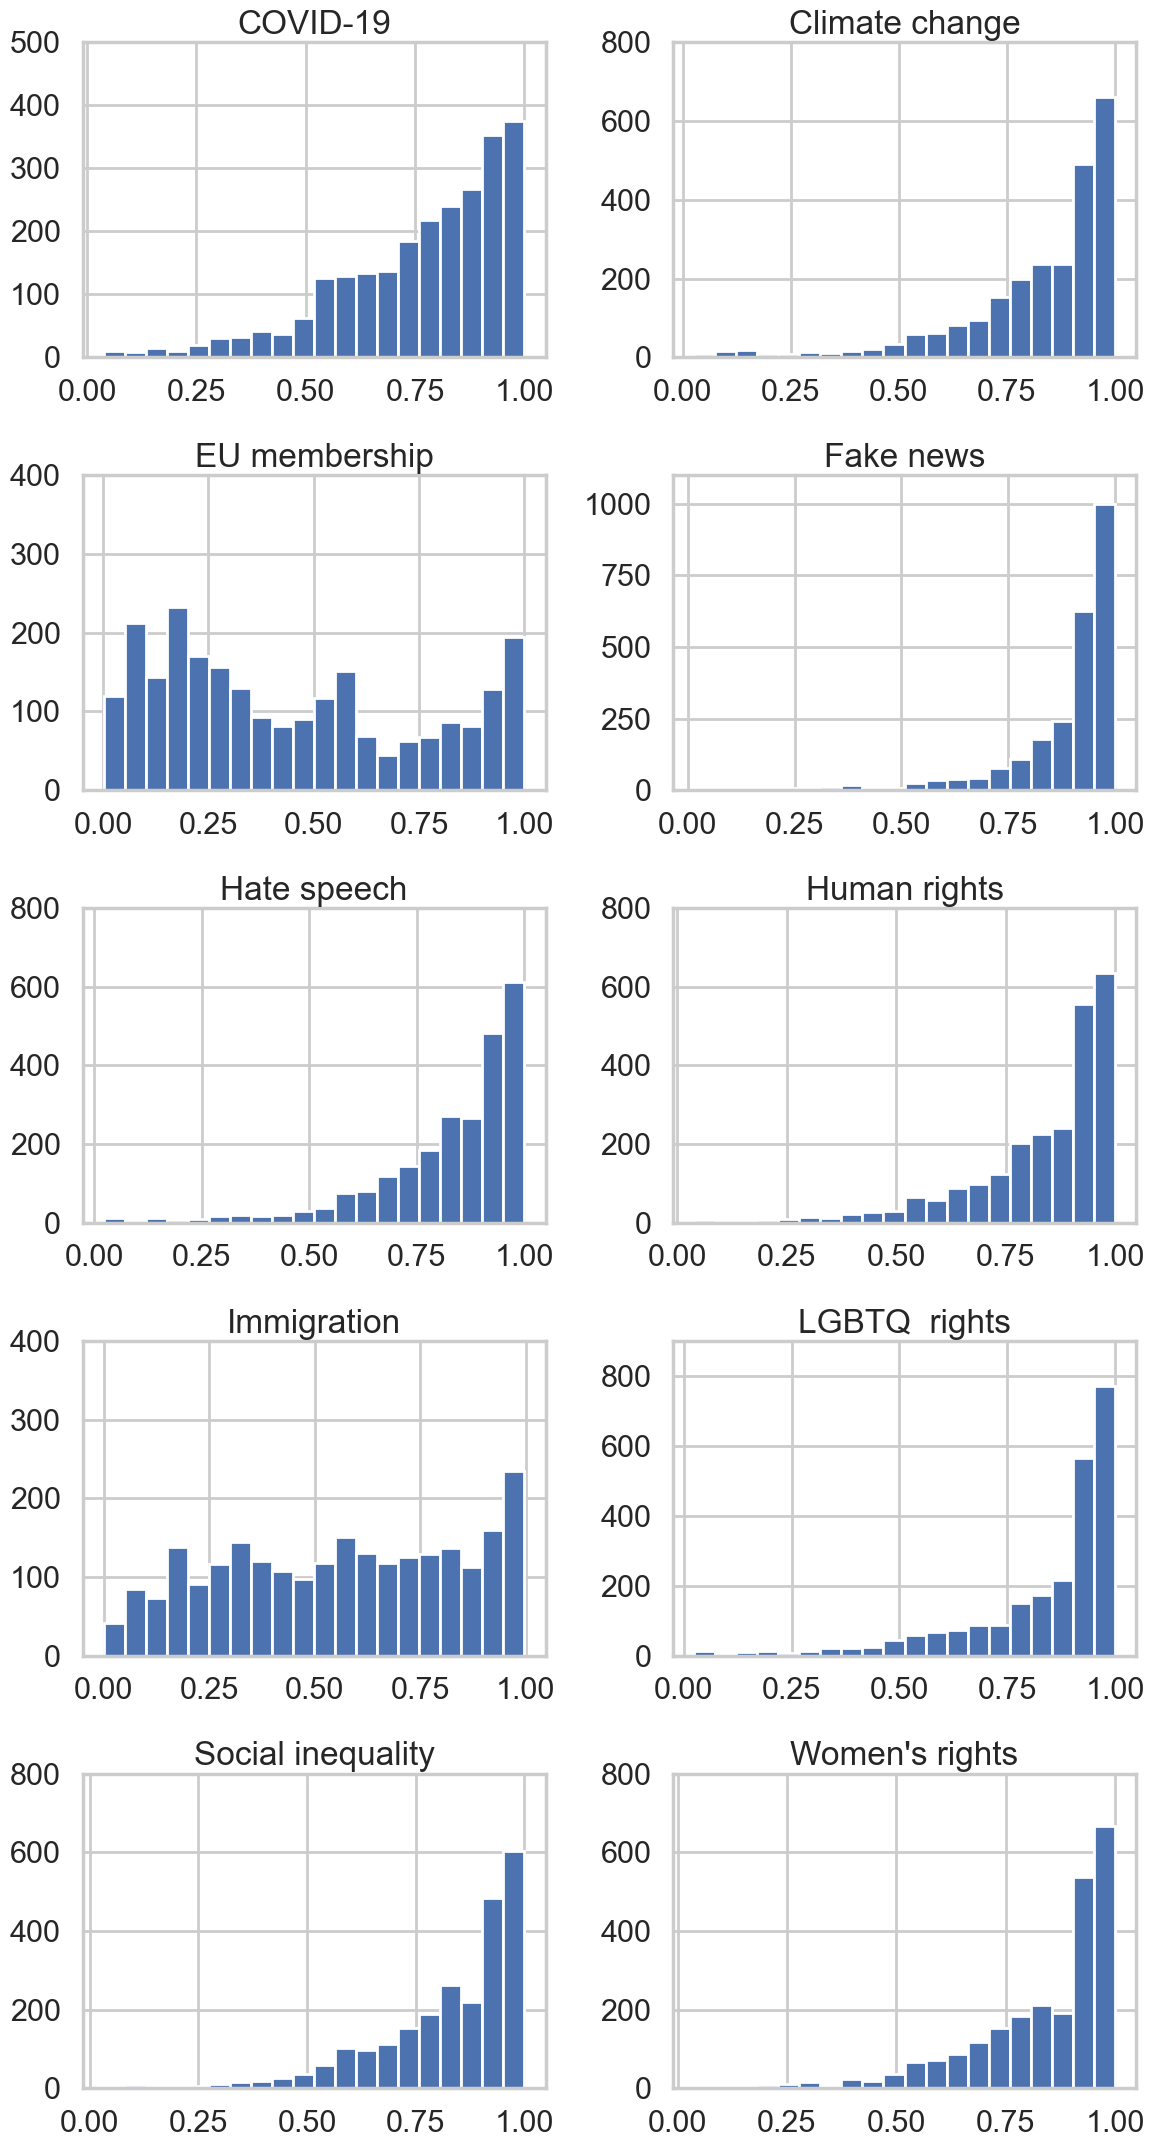

In [30]:
sns.set('poster')
sns.set_style('whitegrid')

df = df_to_be_analysed

issues = sorted([ i for i in df.issue.unique() if 'I ' not in i ])

fig, axs = plt.subplots(5,2,figsize=(12,22))
axs = axs.flatten()

for ax,issue in zip(axs,issues):
    h = ax.hist(df[df.issue==issue].score, bins=20)

    # round the y limits of the plot to next hundred + 100
    ylim = np.ceil(h[0].max()/100)*100 + 100
    ax.set_ylim(0,ylim)
    ax.set_title(issue)

plt.tight_layout()
plt.savefig('images/SI-all-opinion-distributions.png')
plt.show()

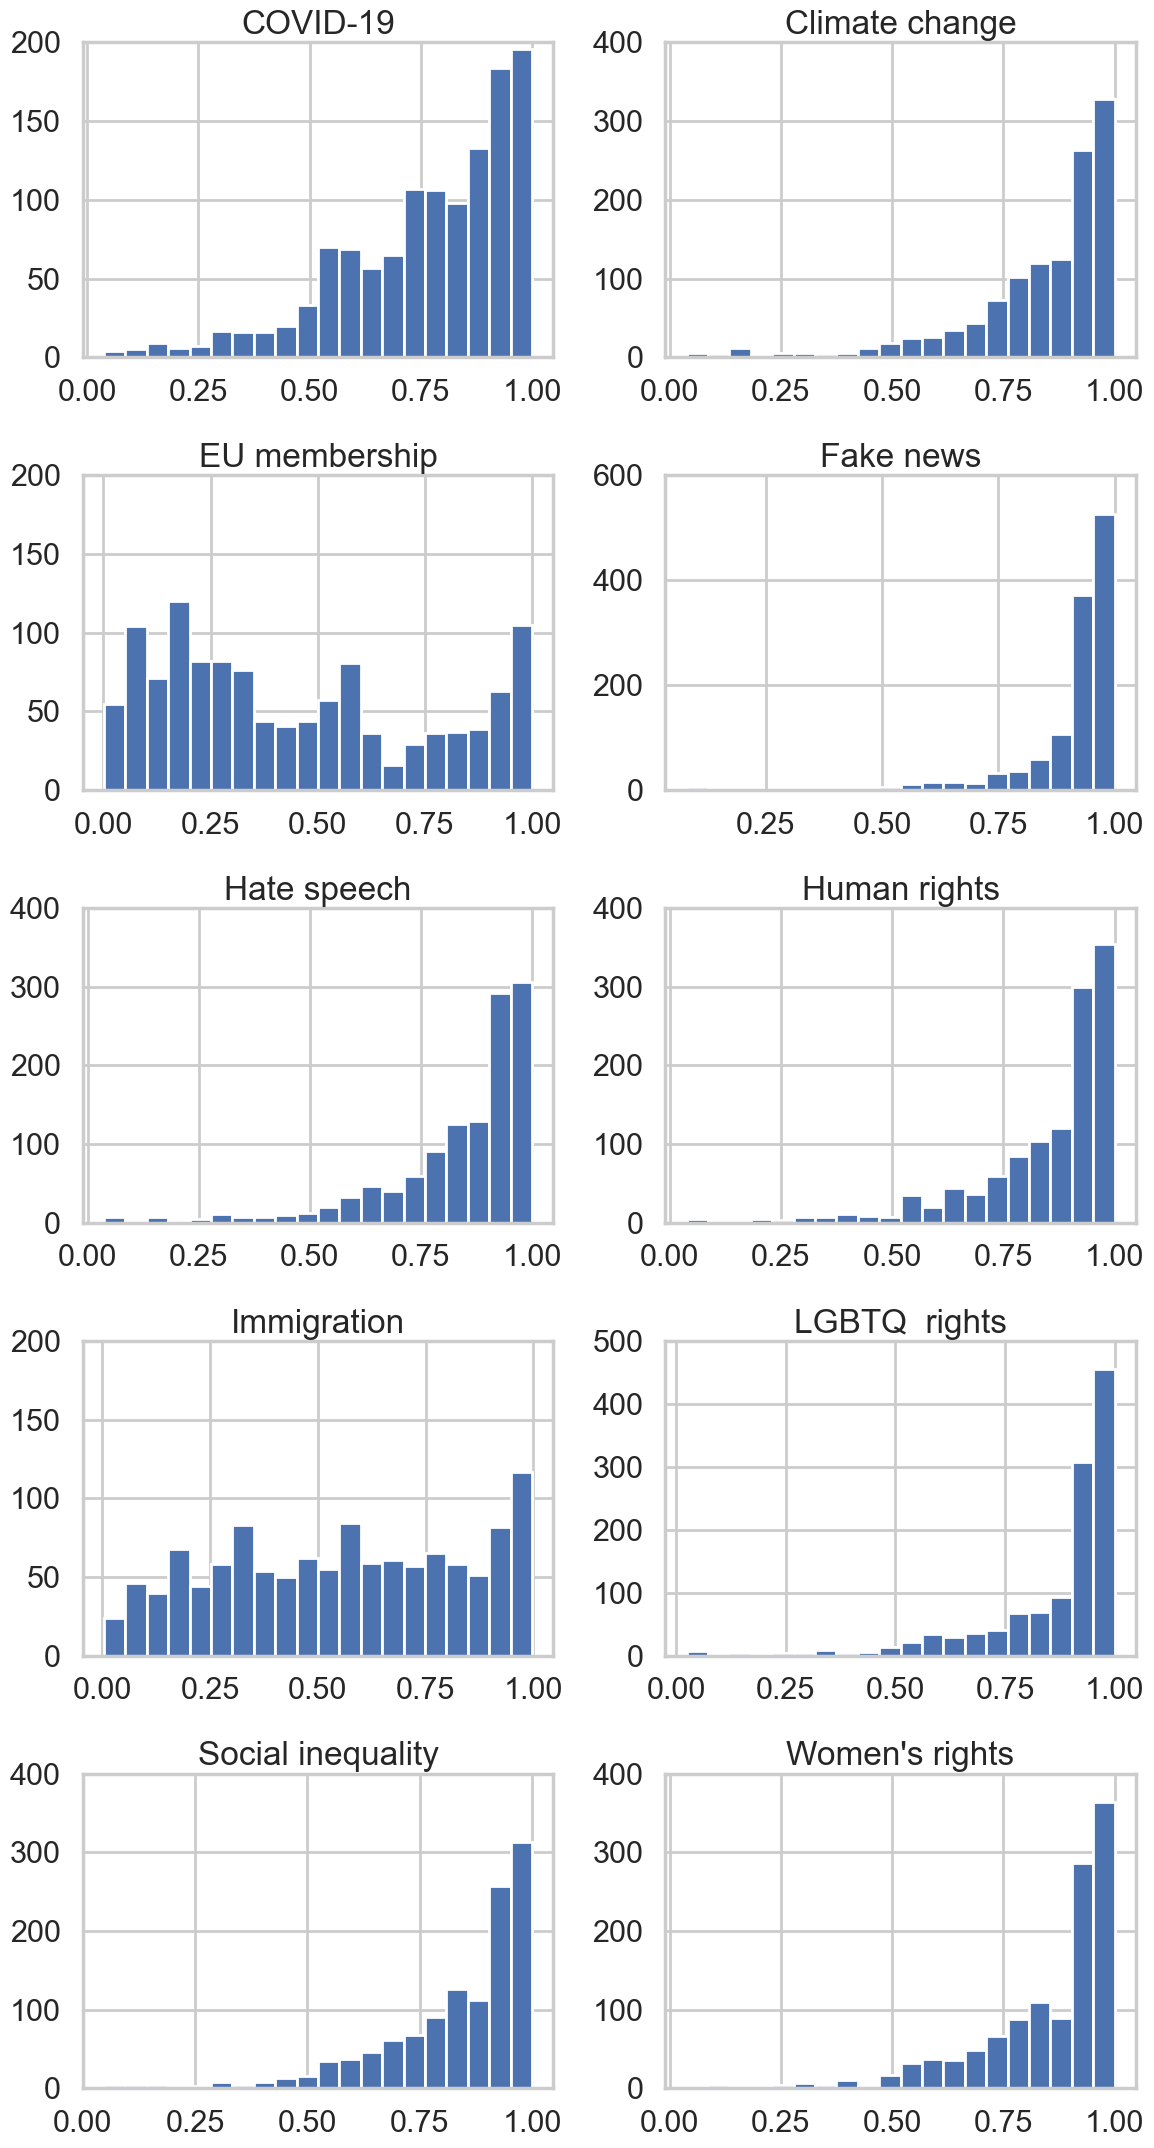

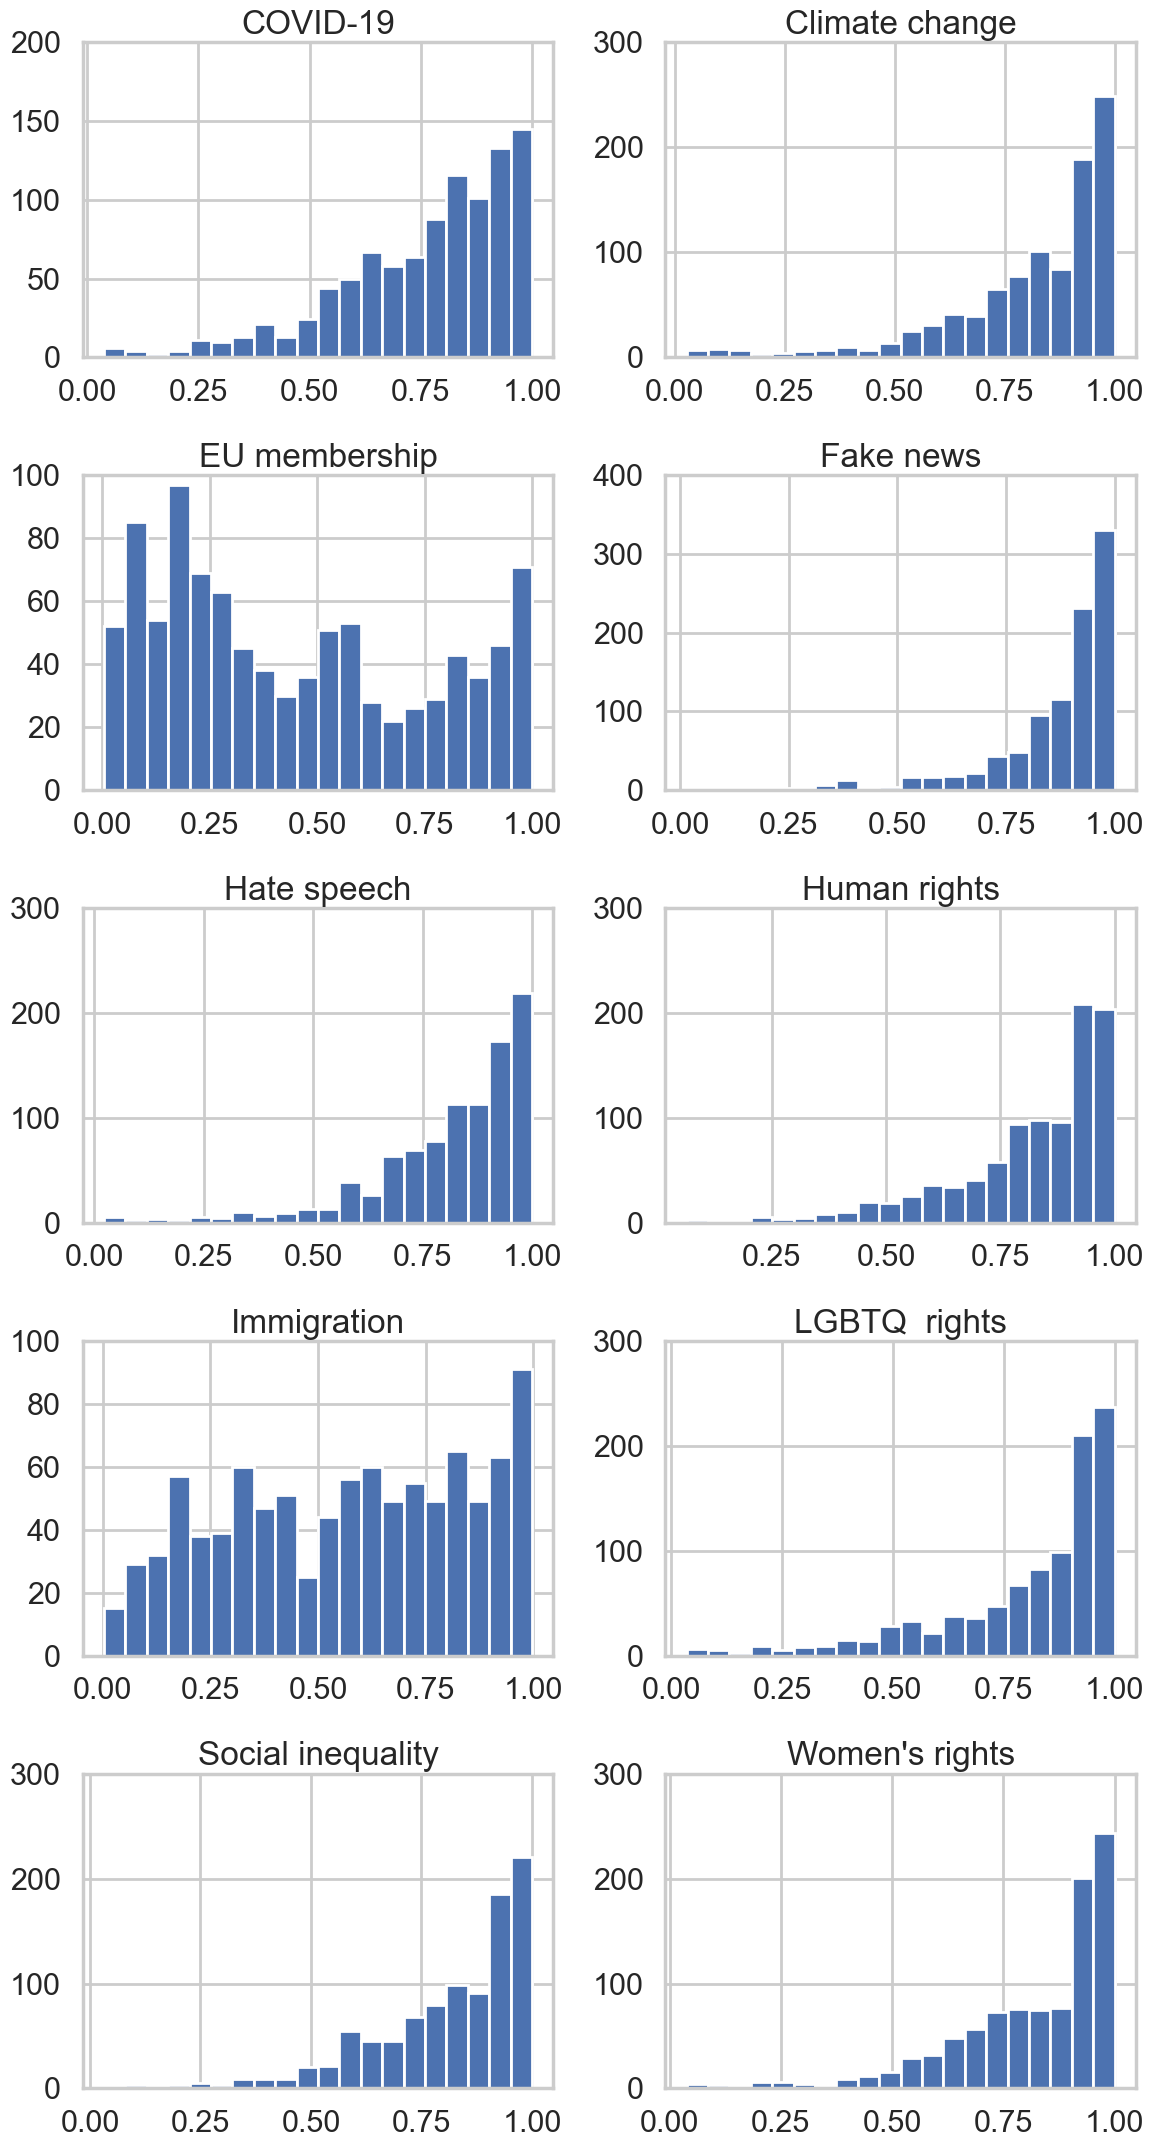

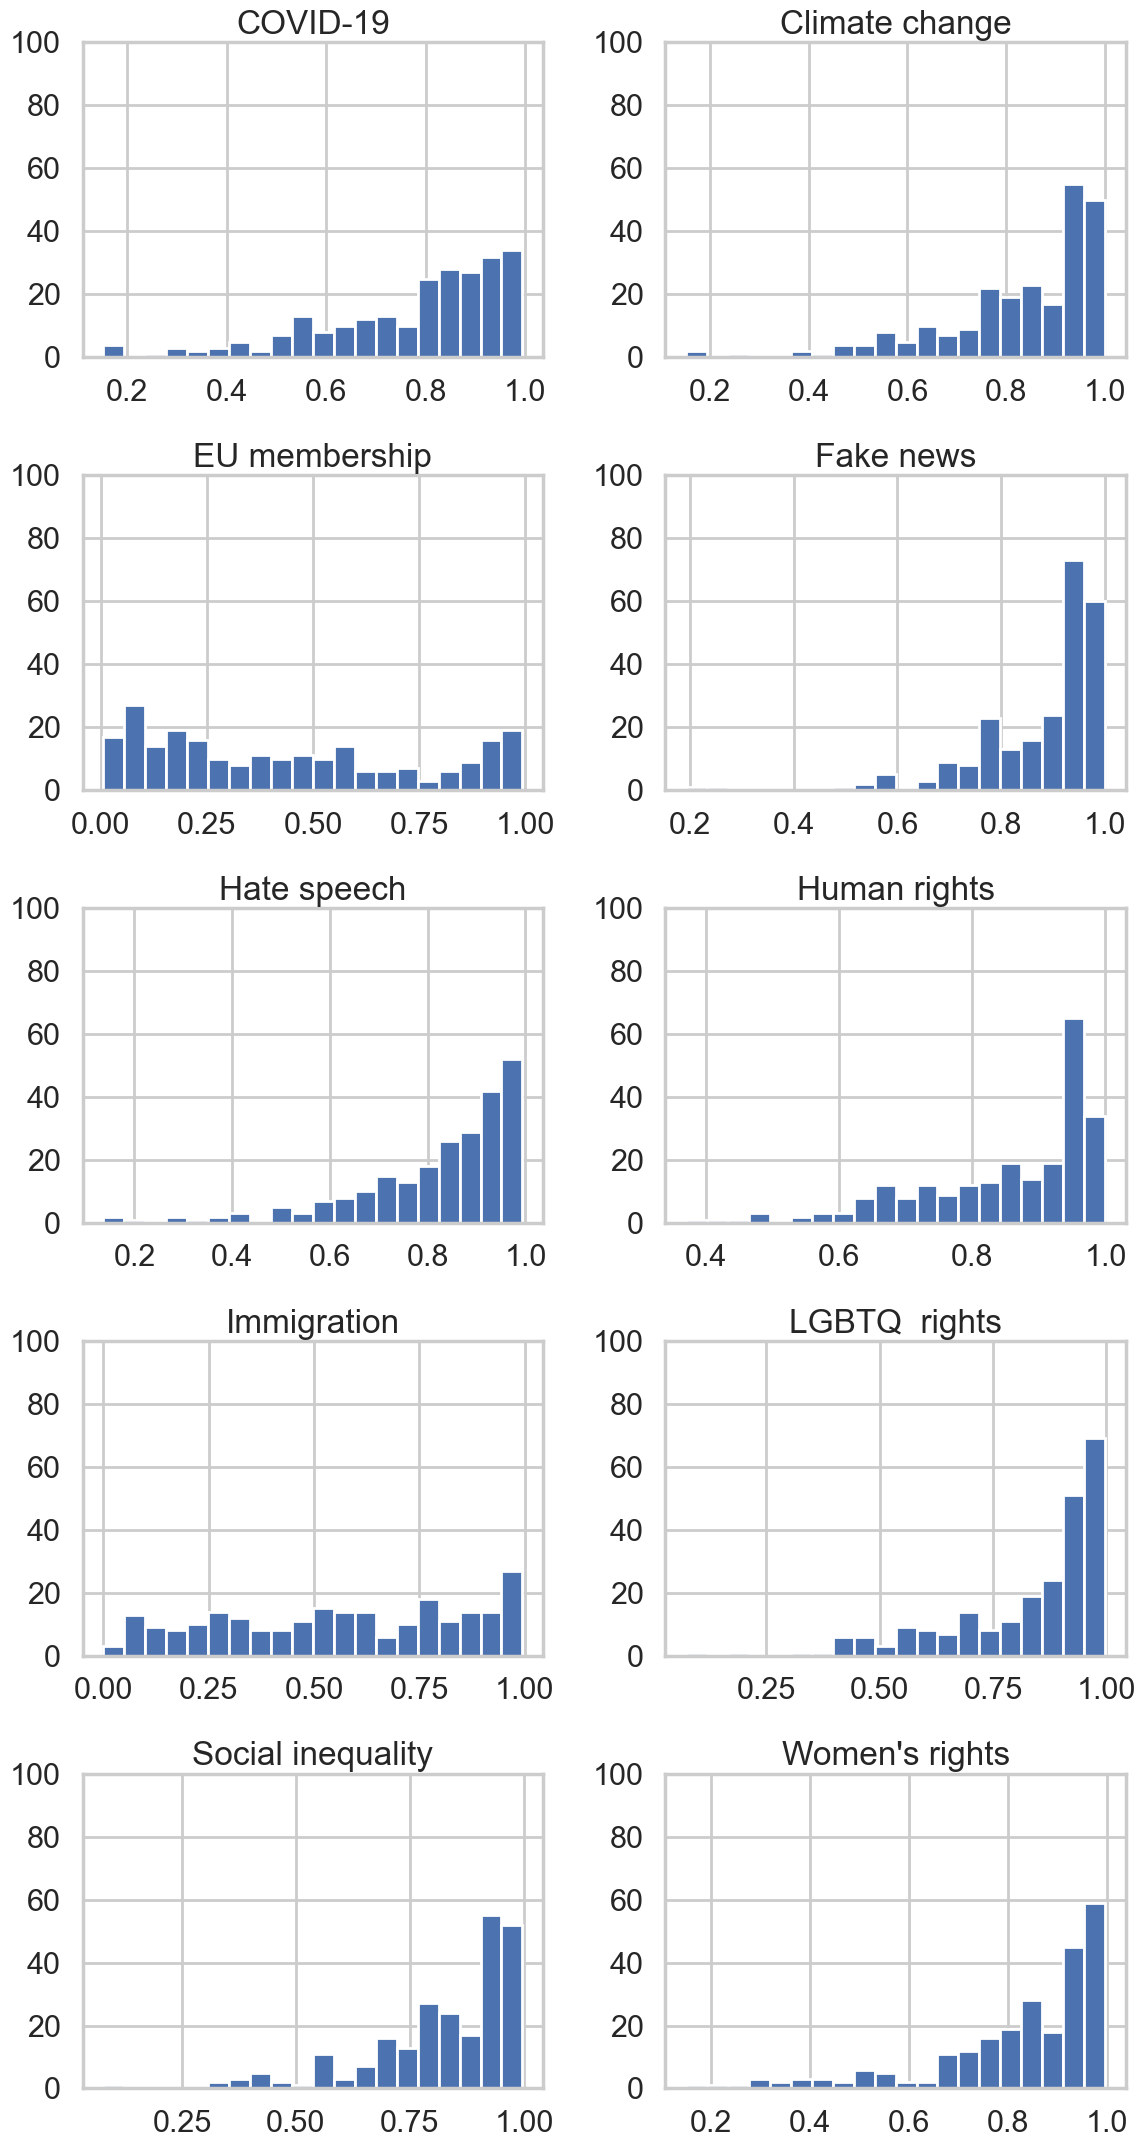

In [31]:
sns.set('poster')
sns.set_style('whitegrid')

df = df_to_be_analysed

issues = sorted([ i for i in df.issue.unique() if 'I ' not in i ])

for wave in ['wave1','wave2_treatment','wave2_control']:
    fig, axs = plt.subplots(5,2,figsize=(12,22))
    axs = axs.flatten()

    for ax,issue in zip(axs,issues):
        h = ax.hist(df.query('(issue == @issue) & (wave==@wave)').score, bins=20)

        # round the y limits of the plot to next hundred + 100
        ylim = np.ceil(h[0].max()/100)*100
        ax.set_ylim(0,ylim)
        ax.set_title(issue)

    plt.tight_layout()
    plt.savefig(f'images/SI-all-opinion-distributions-{wave}.png')
    plt.show()

________________
## SI-Subtraction regression figure for all issues, separately

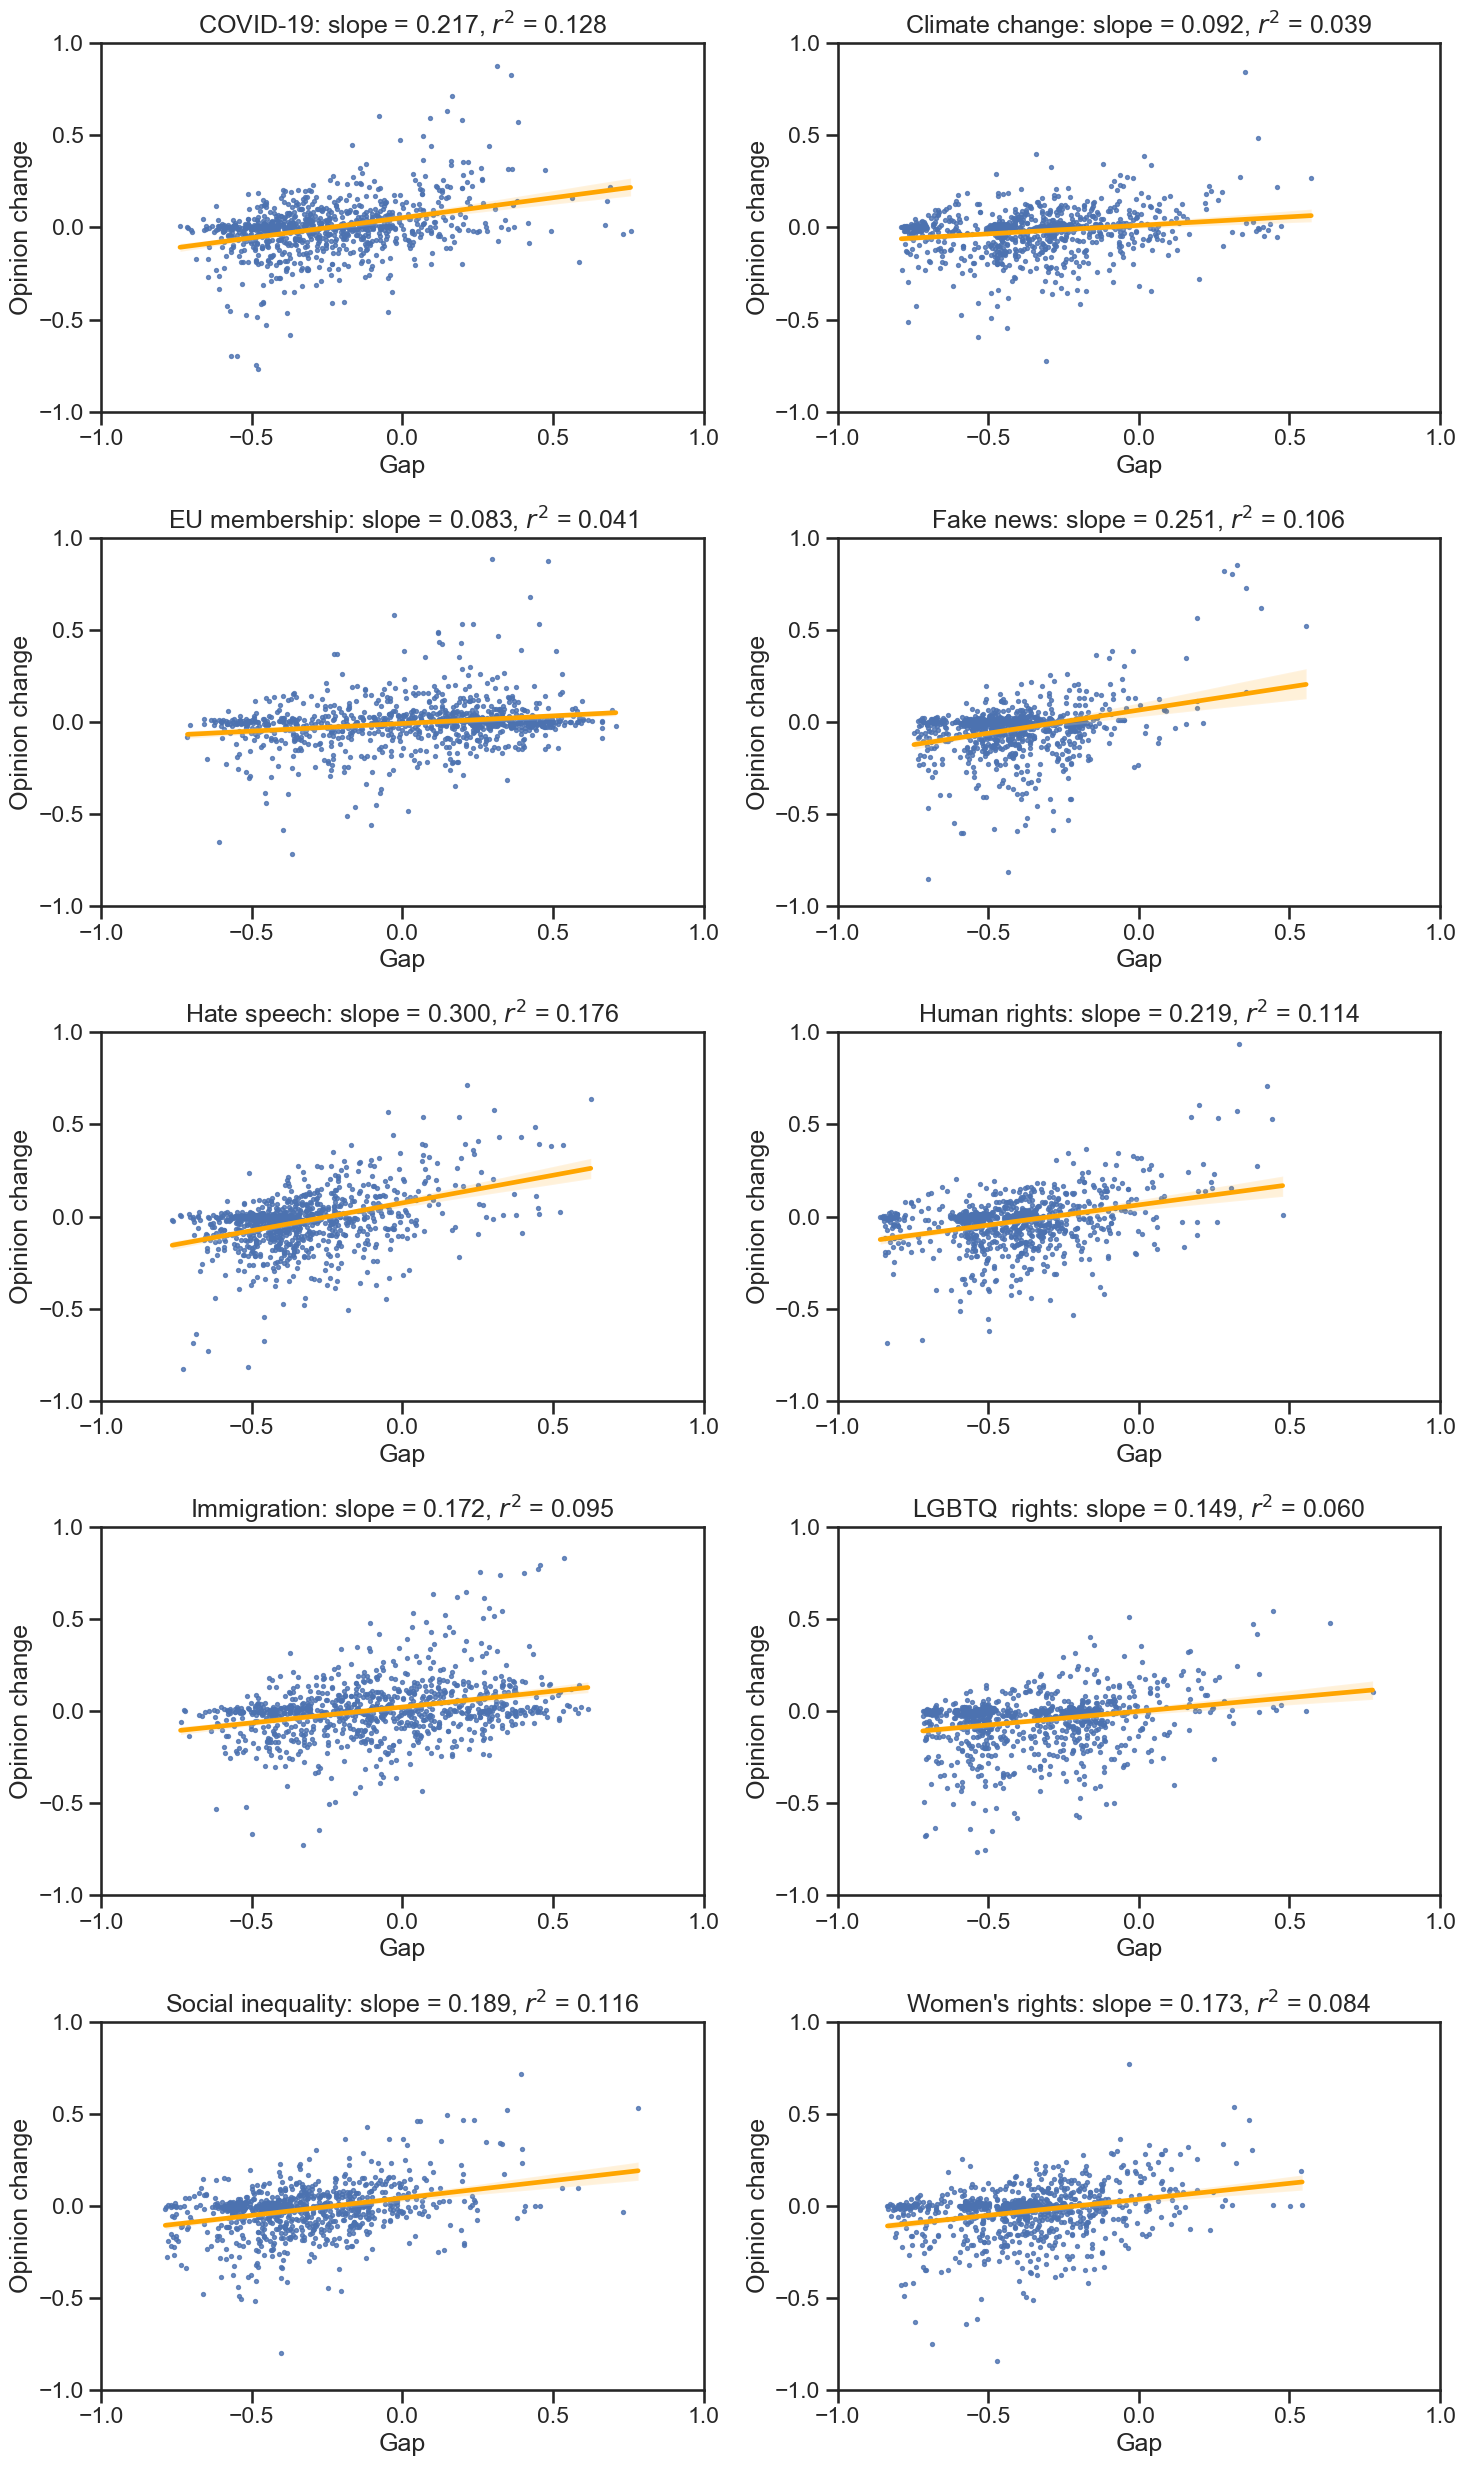

In [32]:
sns.set('talk')
sns.set_style('ticks')

fig, axs = plt.subplots(5,2,figsize=(15,25))

d = df_deltas_treatment.copy()
d['y-x'] = d['soc_info'] - d['w1_score']

for ax, issue in zip(axs.flatten(), issues):
    mask = (df_deltas_treatment.issue==issue)
    sns.regplot(x='y-x', y="delta_score", ax=ax, data=d[mask],
                scatter_kws={'s':8}, line_kws={'color':'orange'})

    title = issue
    
    x = d[mask]['y-x']
    y = d[mask]['delta_score']
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    r_squared = r_value**2
    title += r': slope = {:.3f}, $r^2$ = {:.3f}'.format(slope,r_squared)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticks(np.linspace(-1,1,5))
    ax.set_yticks(np.linspace(-1,1,5))

    ax.set_ylim(-1,1)
    ax.set_xlim(-1,1)
    ax.set_title(title)

    ax.set_ylabel('Opinion change')
    #ax.set_xlabel('Difference between social information and initial opinion')
    ax.set_xlabel('Gap')
    
plt.tight_layout()
plt.savefig('images/SI-subtraction_regression_all_issues.png')
plt.show()

_________
## SI - No relationship between slope and squared error

In [33]:
from scipy.stats import linregress

slopes     = []
r_squareds = []
sqd_errs   = []

df = df_deltas_treatment

userids = sorted(df.userid.unique())
for userid in userids:
    d = df[df.userid==userid]
    y = d.delta_score
    x = d.soc_info-d.w1_score
    #slope, intercept = np.polyfit(x,y,1)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    slopes     += [slope]
    r_squareds += [r_value*r_value]
    sqd_errs   += [std_err*std_err]
    
slopes     = np.array(slopes)
r_squareds = np.array(r_squareds)
sqd_errs   = np.array(sqd_errs)

The relationship between slopes and squared errors has a R^2 of 0.069 (p-value = 1.1589930838440285e-16)


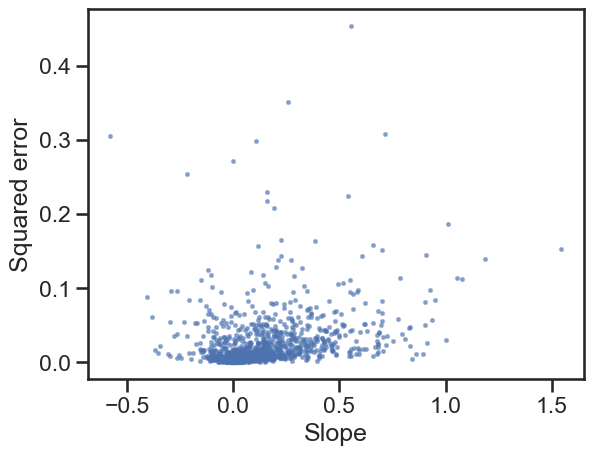

In [34]:
x = slopes
y = sqd_errs
slope, intercept, r_value, p_value, std_err = linregress(x, y)

r2 = round(r_value*r_value,3)
print(f'The relationship between slopes and squared errors has a R^2 of {r2} (p-value = {p_value})')

plt.scatter(slopes,sqd_errs,s=5, alpha=0.5)
plt.ylabel('Squared error')
plt.xlabel('Slope')

plt.savefig('images/SI-no-relationship-between-slope-and-squared-error.png')
plt.show()

__________________
## SI - Personality vs underdog/bandwagon, individual level: no statistical relationship

In [35]:
#  personality_scores[userid] = [agreeableness, openness, conscientiousness, extraversion, neuroticism]

from scipy.stats import linregress

df = df_deltas_treatment
userids = sorted(df.userid.unique())
tuples  = []

for userid in userids:
    try:
        d = df[df.userid==userid]
        y = d.delta_score
        x = d.soc_info-d.w1_score
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        agreeableness, openness, conscientiousness, extraversion, neuroticism = personality_scores[userid]
        tuples += [(userid, slope, agreeableness, openness, conscientiousness, extraversion, neuroticism)]       
    except KeyError:
        continue
        
columns = ['userid', 'slope', 'agreeableness', 'openness', 'conscientiousness', 'extraversion', 'neuroticism']

df_personality_plus_underdog = pd.DataFrame(tuples, columns=columns)
df_personality_plus_underdog['underdog'] = (df_personality_plus_underdog['slope']<0)

df_personality_plus_underdog.head()

,userid,slope,agreeableness,openness,conscientiousness,extraversion,neuroticism,underdog
0,542345f6fdf99b328c91b258,0.195001,0.385043,0.169179,0.567697,0.137246,0.727360,False
1,542bdb6dfdf99b324ea37c3a,0.214927,0.295455,0.732143,0.772727,0.464286,0.159091,False
2,54dfac92fdf99b4b6b6595d9,0.255388,0.394578,0.706325,0.765060,0.195783,0.430723,False
3,555a3e90fdf99b10ecc8713a,0.245255,0.924064,0.645612,0.687763,0.556201,0.664772,False
4,55677786fdf99b7650943938,0.425869,0.512795,0.314471,0.851866,0.762300,0.647144,False


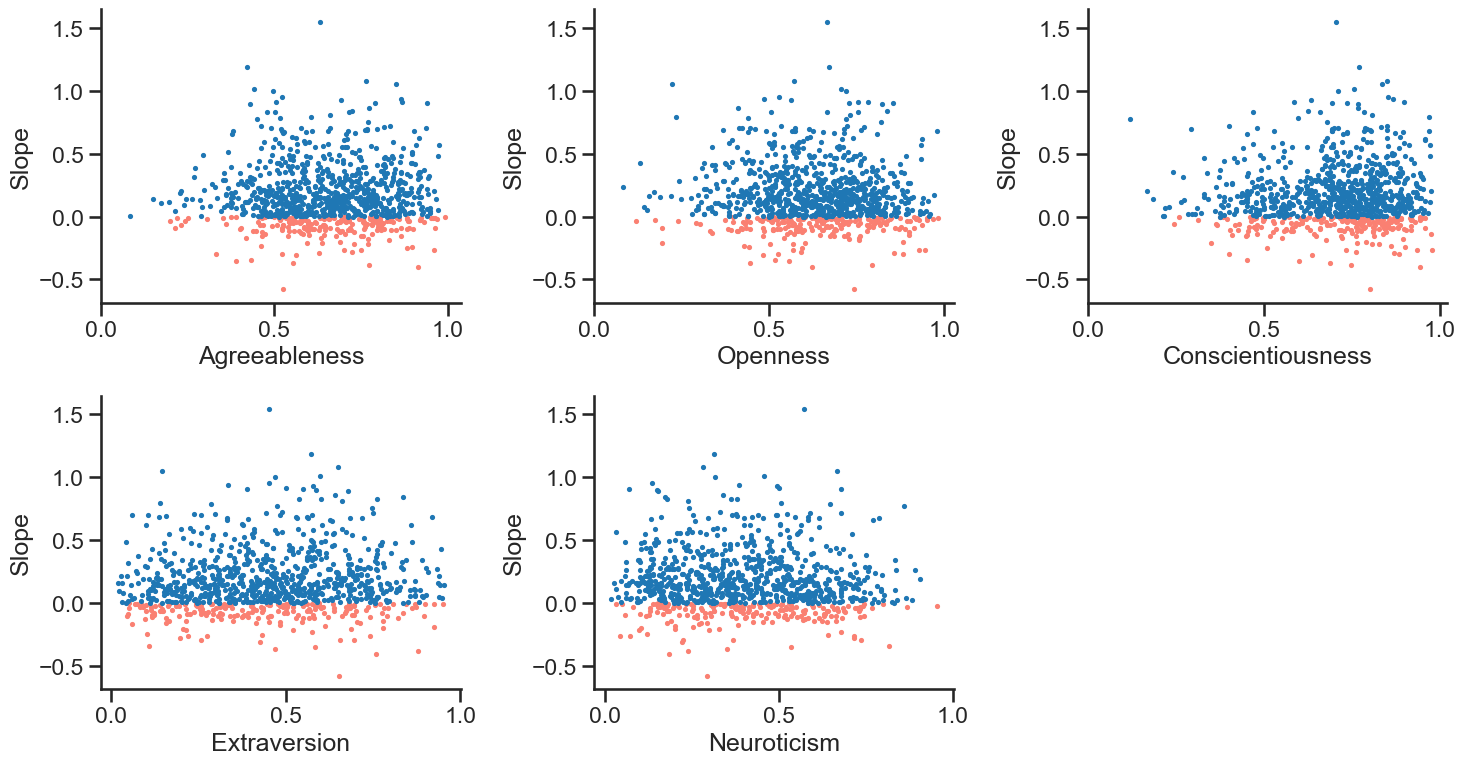

In [36]:
d = df_personality_plus_underdog

fig, axs = plt.subplots(2,3,figsize=(15,8))
axs = axs.flatten()
axs[-1].axis('off')

d2s     = [ d[d.underdog], d[~d.underdog] ] # Split the dataset into underdogs and bandwagons
colours = ['salmon','#1f77b4']

for d2, c in zip(d2s,colours):
    for ax,trait in zip(axs,['agreeableness', 'openness', 'conscientiousness', 'extraversion', 'neuroticism']):
        x = d2[trait]
        y = d2.slope
        ax.scatter(x,y,s=5,c=c)
        ax.set_xlabel(trait.title())
        ax.set_ylabel('Slope')
        ax.set_xticks([0,0.5,1.0])
        ax.set_yticks([-0.5,0,0.5,1,1.5])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig('images/SI-no-statistical-relationship-between-personality-and-underdog.png')
plt.show()

### Another plot showing the same: no statistical relationship.

In [37]:
d = df_personality_plus_underdog

columns = ['agreeableness', 'openness', 'conscientiousness', 'extraversion', 'neuroticism']
d2s     = [ d[d.underdog][columns].melt(), d[~d.underdog][columns].melt() ] # Split the dataset into underdogs and bandwagons

d2s[0]['underdog'] = 'Underdog'
d2s[1]['underdog'] = 'Bandwagon'

d2 = pd.concat(d2s)

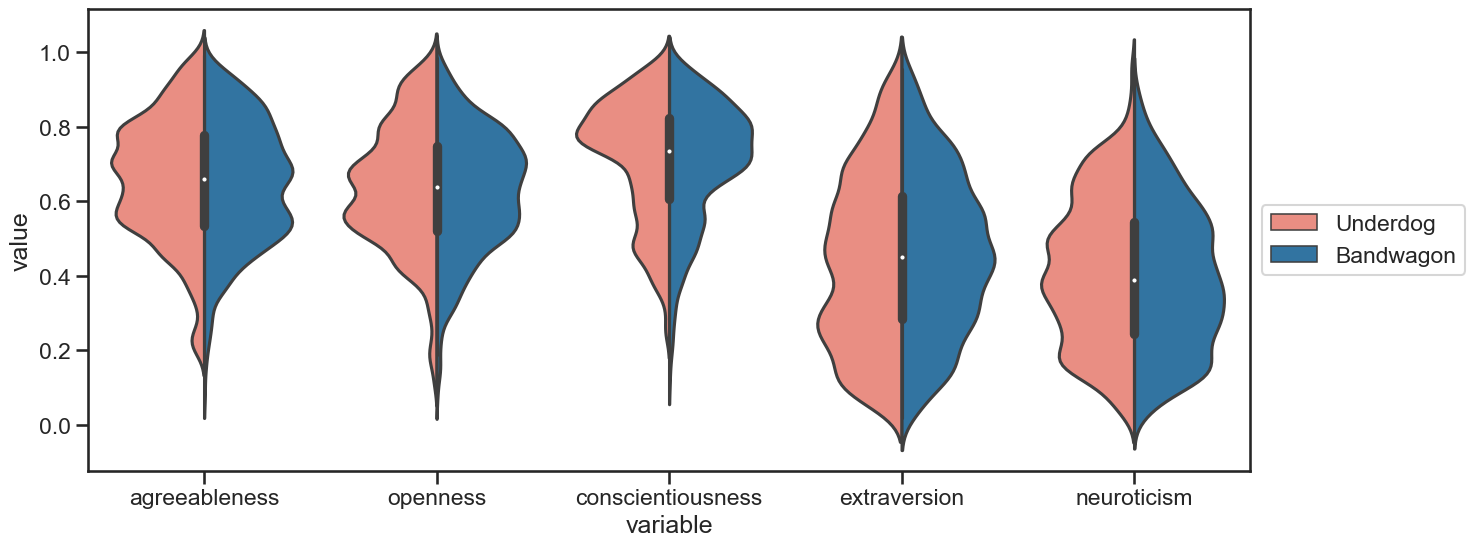

In [38]:
fig, ax = plt.subplots(figsize=(15,6))

g = sns.violinplot(x="variable", y="value", hue="underdog", data=d2, palette=['salmon','#1f77b4'], split=True, bw=.2, ax=ax)

# Put the legend out of the figure
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('images/SI-no-statistical-relationship-between-personality-and-underdog-2.png')
plt.show()

In [39]:
for col in columns:
    u = d[d.underdog][col]
    v = d[~d.underdog][col]
    t_value, p_value = compare_ttest(u,v)
    p_value = round(p_value,5)
    print(f'Regarding {col},'.ljust(28), f' underdog and bandwagon are indistinguishable: p-value = {p_value}')

Regarding agreeableness,      underdog and bandwagon are indistinguishable: p-value = 0.41215
Regarding openness,           underdog and bandwagon are indistinguishable: p-value = 0.32575
Regarding conscientiousness,  underdog and bandwagon are indistinguishable: p-value = 0.52603
Regarding extraversion,       underdog and bandwagon are indistinguishable: p-value = 0.15724
Regarding neuroticism,        underdog and bandwagon are indistinguishable: p-value = 0.21791


__________
## SI - No evidence of threshold

Here I try to fit a piecewise linear function, so in theory we could get a S-shaped curve.

In summary, it doesn't produce anything that looks like a threshold function.

In [40]:
d = df_deltas_treatment

y = d.delta_score
x = d.soc_info-d.w1_score

idxs = np.argsort(x)
x = x.values[idxs]
y = y.values[idxs]

In [41]:
# https://gist.github.com/ruoyu0088/70effade57483355bbd18b31dc370f2a

from scipy.optimize import minimize

def segments_fit(X, Y, count):
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count)

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2)**2)

    r = minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    return func(r.x)

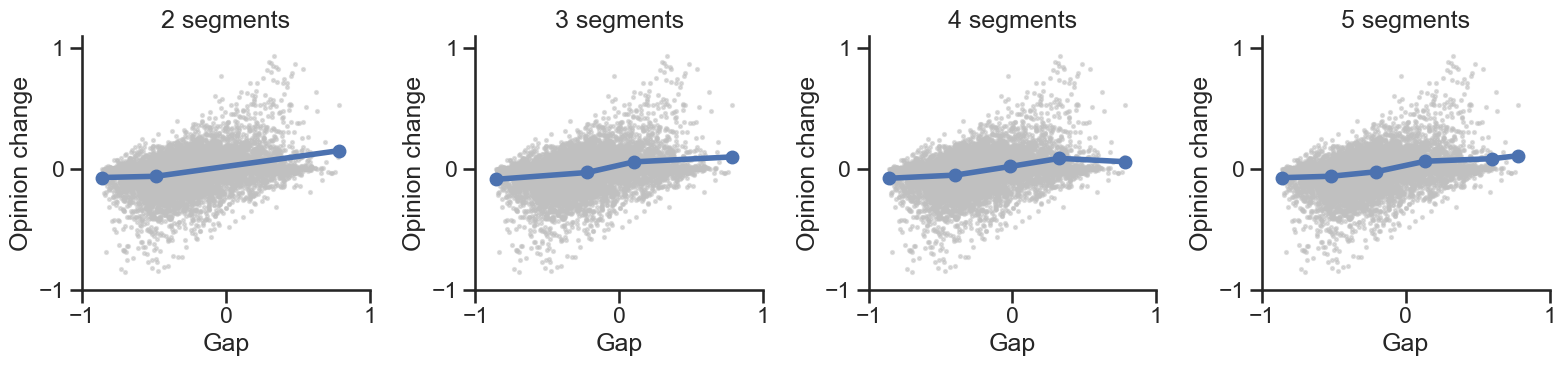

In [42]:
fig, axs = plt.subplots(1,4,figsize=(16,4))
axs = axs.flatten()
ns = [2,3,4,5]

for ax, nsegments in zip(axs, ns):
    xfit, yfit = segments_fit(x, y, nsegments)
    ax.scatter(x,y, s=5, alpha=0.5, c='silver')
    ax.plot(xfit, yfit, 'o-', lw=4, c='b')
    
    ax.set_xticks([-1,0,1])
    ax.set_yticks([-1,0,1])
    ax.set_ylim(-1,1.1)
    ax.set_ylabel('Opinion change')
    ax.set_xlabel('Gap')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(f'{nsegments} segments')
    
plt.tight_layout()
plt.savefig('images/SI-no-threshold-behaviour.png')
plt.show()

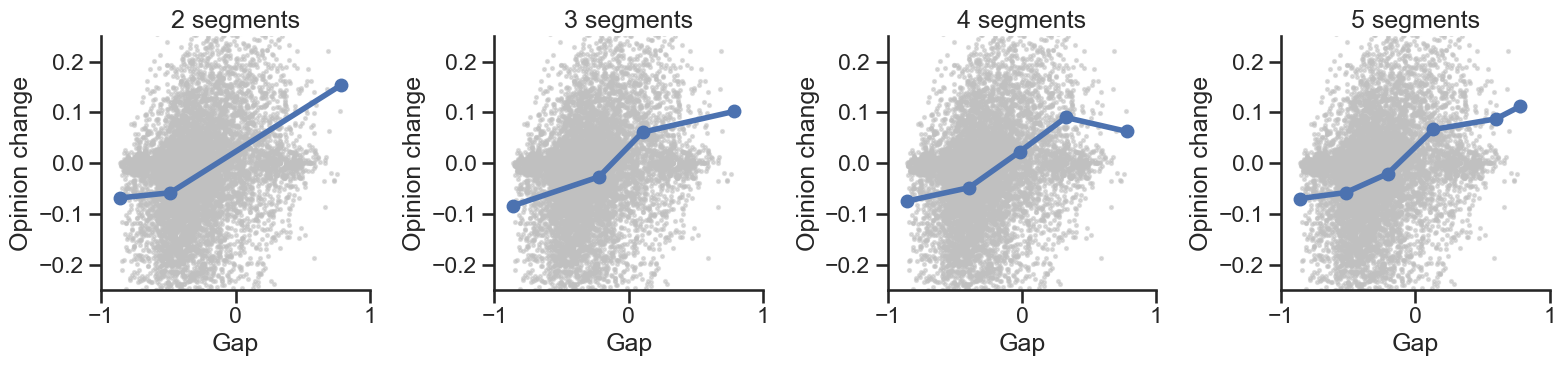

In [43]:
fig, axs = plt.subplots(1,4,figsize=(16,4))
axs = axs.flatten()
ns = [2,3,4,5]

for ax, nsegments in zip(axs, ns):
    xfit, yfit = segments_fit(x, y, nsegments)
    ax.scatter(x,y, s=5, alpha=0.5, c='silver')
    ax.plot(xfit, yfit, 'o-', lw=4, c='b')
    
    ax.set_xticks([-1,0,1])
    ax.set_ylim(-0.25,0.25)
    ax.set_ylabel('Opinion change')
    ax.set_xlabel('Gap')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(f'{nsegments} segments')
    
plt.tight_layout()
plt.savefig('images/SI-no-threshold-behaviour-zoomed-in.png')
plt.show()

___________

## SI - Plot opinion 1 vs opinion 2, splitting on social info

In [44]:
d = df_deltas_treatment.copy()
d['w2_score'] = d['w1_score'] + d['delta_score']

d['contrarian'] = d.userid.apply(lambda x: (x in contrarians))

NameError: name 'contrarians' is not defined

In [ ]:
socinfo_bins = [ 0, 0.4, 0.45, 0.50, 0.55, 0.60, 1.00 ]
# minority support (0-40%)
# “large-minority” support (40-45%)
# just-minority support (45-50%)
# just-majority support (50-55%)
# “small-majority” support (55-60%)
# majority support (60-100%)

bin_labels = sorted([ str(i) for i in pd.cut(d['soc_info'], bins=socinfo_bins).value_counts().keys()])

d['soc_info_bin'] = pd.cut(d['soc_info'], bins=socinfo_bins, labels=bin_labels)

opinion_bins = np.linspace(0,1,7)
opinion_bin_labels = sorted([ str(i) for i in pd.cut(d['w1_score'], bins=opinion_bins).value_counts().keys()])
d['w1_score_bin'] = pd.cut(d['w1_score'], bins=opinion_bins, labels=opinion_bin_labels)

d

,userid,group,issue,delta_score,delta_ranking,soc_info,w1_score,w1_ranking,w2_score,contrarian,soc_info_bin,w1_score_bin
0,5cb4b1cc96d87400010836bd,treatment,Human rights,-0.081636,0,0.55,0.977205,1,0.895570,False,"(0.5, 0.55]","(0.833, 1.0]"
1,5cb4b1cc96d87400010836bd,treatment,Climate change,-0.515180,0,0.21,0.977205,4,0.462025,False,"(0.0, 0.4]","(0.833, 1.0]"
2,5cb4b1cc96d87400010836bd,treatment,Immigration,-0.170243,3,0.48,0.977205,2,0.806962,False,"(0.45, 0.5]","(0.833, 1.0]"
3,5cb4b1cc96d87400010836bd,treatment,Hate speech,0.306962,1,0.55,0.655063,6,0.962025,False,"(0.5, 0.55]","(0.5, 0.667]"
4,5cb4b1cc96d87400010836bd,treatment,Social inequality,-0.022152,-3,0.51,0.658228,9,0.636076,False,"(0.5, 0.55]","(0.5, 0.667]"
...,...,...,...,...,...,...,...,...,...,...,...,...
11935,5e99760adc79bf1a87441b86,treatment,LGBTQ rights,0.000000,0,0.28,0.980370,5,0.980370,False,"(0.0, 0.4]","(0.833, 1.0]"
11936,5e99760adc79bf1a87441b86,treatment,Social inequality,0.000000,1,0.66,0.980370,3,0.980370,False,"(0.6, 1.0]","(0.833, 1.0]"
11937,5e99760adc79bf1a87441b86,treatment,Women's rights,0.091129,-1,0.54,0.889241,4,0.980370,False,"(0.5, 0.55]","(0.833, 1.0]"
11938,5e99760adc79bf1a87441b86,treatment,EU membership,-0.104430,-1,0.42,0.231013,9,0.126582,False,"(0.4, 0.45]","(0.167, 0.333]"


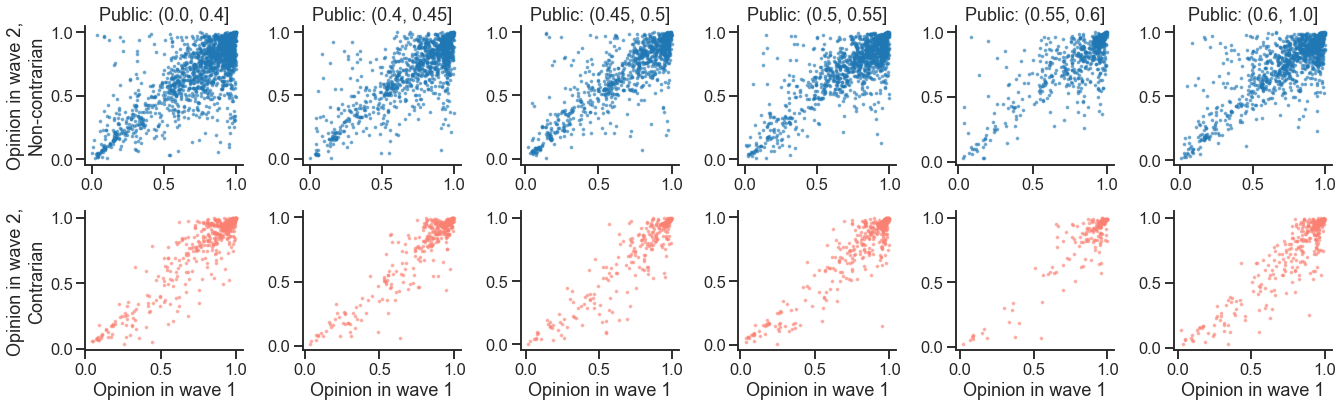

In [ ]:
fig, axs = plt.subplots(2,6,figsize=(19,6))

for axi,contrarian_status,c in zip(axs,[False,True],['#1f77b4','salmon']):
    for ax, bin_label in zip(axi, bin_labels):

        mask = (d['soc_info_bin']==bin_label) & (d['contrarian']==contrarian_status)
        x = d[mask]['w1_score']
        y = d[mask]['w2_score']

        idxs = np.argsort(x)
        x = x.values[idxs]
        y = y.values[idxs]   
        
        ax.scatter(x,y, s=5, alpha=0.5, c=c)

        #slope, intercept, r_value, p_value, std_err = linregress(x, y)
        #print(contrarian_status, bin_label, round(slope,3), round(r_value*r_value,3))
        #xfit = np.array([0,1])
        #yfit = slope*xfit+intercept
        #ax.plot(xfit,yfit,'-',c='orange',lw=2)

        ax.set_xticks([0,0.5,1])
        ax.set_yticks([0,0.5,1])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

axs[0,0].set_ylabel('Opinion in wave 2,\nNon-contrarian')
axs[1,0].set_ylabel('Opinion in wave 2,\nContrarian')

for ax in axs[1,:]:
    ax.set_xlabel('Opinion in wave 1')

for ax,bin_label in zip(axs[0,:],bin_labels):
    ax.set_title('Public: '+bin_label, pad=5)
    
plt.tight_layout()
plt.savefig('images/SI-opinion-change-binned-per-socinfo.png')
plt.show()

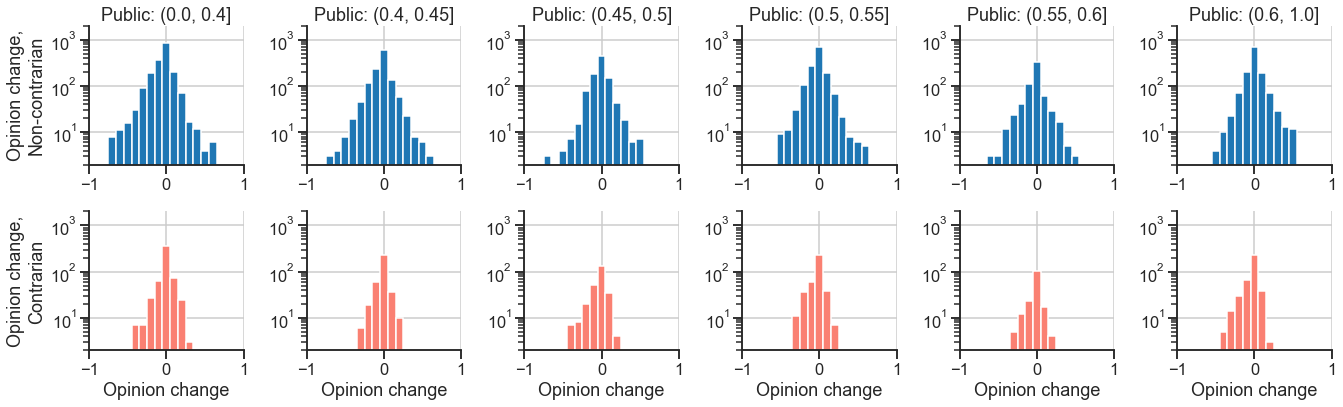

In [ ]:
bins_opinion = np.linspace(-.75,.75,16)

fig, axs = plt.subplots(2,6,figsize=(19,6))

for axi,contrarian_status,c in zip(axs,[False,True],['#1f77b4','salmon']):
    for ax, bin_label in zip(axi, bin_labels):

        mask = (d['soc_info_bin']==bin_label) & (d['contrarian']==contrarian_status)

        d[mask]['delta_score'].hist(bins=bins_opinion, ax=ax, color=c)

        ax.set_xlim(-1,1)
        ax.set_yscale('log')
        ax.set_ylim(2,2e3)
        ax.set_yticks([1e1,1e2,1e3])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

axs[0,0].set_ylabel('Opinion change,\nNon-contrarian')
axs[1,0].set_ylabel('Opinion change,\nContrarian')

for ax in axs[1,:]:
    ax.set_xlabel('Opinion change')

for ax,bin_label in zip(axs[0,:],bin_labels):
    ax.set_title('Public: '+bin_label, pad=5)
    
plt.tight_layout()
plt.savefig('images/SI-opinion-change-binned-per-socinfo-2.png')
plt.show()

___________________

## SI - Plot opinion 2 vs soc info

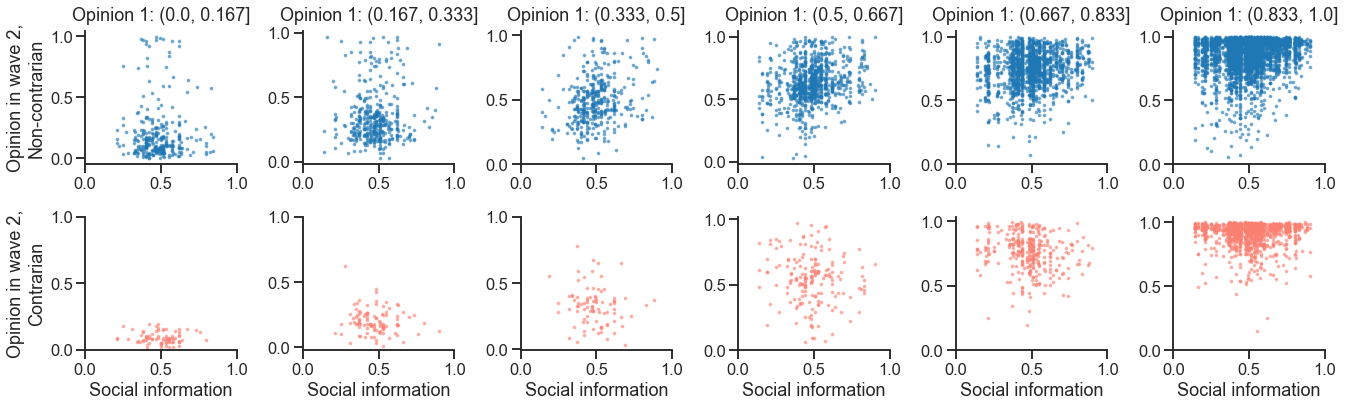

In [ ]:
fig, axs = plt.subplots(2,6,figsize=(19,6))

for axi,contrarian_status,c in zip(axs,[False,True],['#1f77b4','salmon']):
    for ax, bin_label in zip(axi, opinion_bin_labels):

        mask = (d['w1_score_bin']==bin_label) & (d['contrarian']==contrarian_status)
        x = d[mask]['soc_info']
        y = d[mask]['w2_score']

        idxs = np.argsort(x)
        x = x.values[idxs]
        y = y.values[idxs]   
        
        ax.scatter(x,y, s=5, alpha=0.5, c=c)

        #slope, intercept, r_value, p_value, std_err = linregress(x, y)
        #print(contrarian_status, bin_label, round(slope,3), round(r_value*r_value,3))
        #xfit = np.array([0,1])
        #yfit = slope*xfit+intercept
        #ax.plot(xfit,yfit,'-',c='orange',lw=2)

        ax.set_xticks([0,0.5,1])
        ax.set_yticks([0,0.5,1])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

axs[0,0].set_ylabel('Opinion in wave 2,\nNon-contrarian')
axs[1,0].set_ylabel('Opinion in wave 2,\nContrarian')

for ax in axs[1,:]:
    ax.set_xlabel('Social information')

for ax,bin_label in zip(axs[0,:],opinion_bin_labels):
    ax.set_title('Opinion 1: '+bin_label, pad=10)
    
plt.tight_layout()
plt.savefig('images/SI-responsiveness-binned-per-opinion1.png')
plt.show()

_________
## SI - No relationship between slope and squared error

In [ ]:
from scipy.stats import linregress

slopes2     = []
r_squareds2 = []
sqd_errs2   = []

df = df_deltas_treatment

userids = sorted(df.userid.unique())
for userid in userids:
    d = df[df.userid==userid]
    y = d.delta_score
    x = d.soc_info
    #slope, intercept = np.polyfit(x,y,1)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    slopes2     += [slope]
    r_squareds2 += [r_value*r_value]
    sqd_errs2   += [std_err*std_err]
    
slopes2     = np.array(slopes2)
r_squareds2 = np.array(r_squareds2)
sqd_errs2   = np.array(sqd_errs2)

The relationship between slopes and squared errors has a R^2 of 0.001 (p-value = 0.47730748765541764)


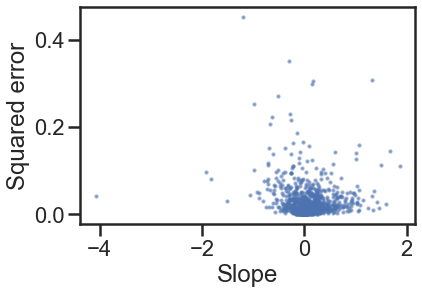

In [ ]:
x = slopes2
y = sqd_errs2
slope, intercept, r_value, p_value, std_err = linregress(x, y)

r2 = round(r_value*r_value,3)
print(f'The relationship between slopes and squared errors has a R^2 of {r2} (p-value = {p_value})')

plt.scatter(slopes2,sqd_errs,s=5, alpha=0.5)
plt.ylabel('Squared error')
plt.xlabel('Slope')
#plt.ylim(-0.1,1.6)
#plt.xlim(-2.1,2.1)

plt.savefig('images/SI-no-relationship-between-slope2-and-squared-error.png')
plt.show()

__________________
## SI - Personality vs underdog/bandwagon, individual level: no statistical relationship

In [ ]:
#  personality_scores[userid] = [agreeableness, openness, conscientiousness, extraversion, neuroticism]

from scipy.stats import linregress

df = df_deltas_treatment
userids = sorted(df.userid.unique())
tuples  = []

for userid in userids:
    try:
        d = df[df.userid==userid]
        y = d.delta_score
        x = d.soc_info
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        agreeableness, openness, conscientiousness, extraversion, neuroticism = personality_scores[userid]
        tuples += [(userid, slope, agreeableness, openness, conscientiousness, extraversion, neuroticism)]       
    except KeyError:
        continue
        
columns = ['userid', 'slope', 'agreeableness', 'openness', 'conscientiousness', 'extraversion', 'neuroticism']

df_personality_plus_underdog = pd.DataFrame(tuples, columns=columns)
df_personality_plus_underdog['underdog'] = (df_personality_plus_underdog['slope']<0)

df_personality_plus_underdog.head()

,userid,slope,agreeableness,openness,conscientiousness,extraversion,neuroticism,underdog
0,542345f6fdf99b328c91b258,-0.076031,0.385043,0.169179,0.567697,0.137246,0.727360,True
1,542bdb6dfdf99b324ea37c3a,-0.019906,0.295455,0.732143,0.772727,0.464286,0.159091,True
2,54dfac92fdf99b4b6b6595d9,0.037473,0.394578,0.706325,0.765060,0.195783,0.430723,False
3,555a3e90fdf99b10ecc8713a,0.013073,0.924064,0.645612,0.687763,0.556201,0.664772,False
4,55677786fdf99b7650943938,0.311701,0.512795,0.314471,0.851866,0.762300,0.647144,False


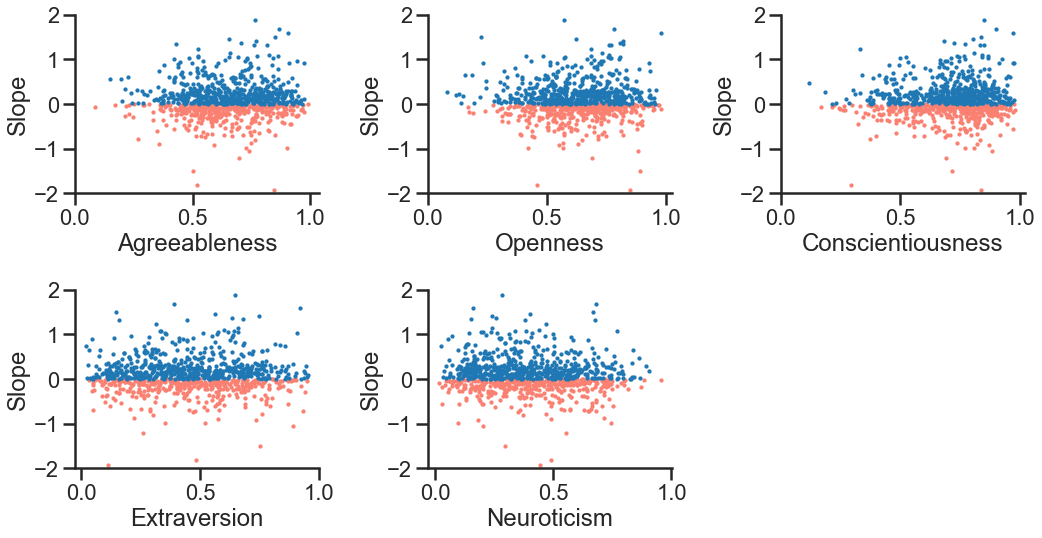

In [ ]:
d = df_personality_plus_underdog

fig, axs = plt.subplots(2,3,figsize=(15,8))
axs = axs.flatten()
axs[-1].axis('off')

d2s     = [ d[d.underdog], d[~d.underdog] ] # Split the dataset into underdogs and bandwagons
colours = ['salmon','#1f77b4']

for d2, c in zip(d2s,colours):
    for ax,trait in zip(axs,['agreeableness', 'openness', 'conscientiousness', 'extraversion', 'neuroticism']):
        x = d2[trait]
        y = d2.slope
        ax.scatter(x,y,s=5,c=c)
        ax.set_xlabel(trait.title())
        ax.set_ylabel('Slope')
        ax.set_xticks([0,0.5,1.0])
        #ax.set_yticks([-1.5,-1.0,-0.5,0,0.5,1,1.5])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim(-2,2)

plt.tight_layout()

plt.savefig('images/SI-no-statistical-relationship-between-personality-and-underdog-2.png')
plt.show()

### Another plot showing the same: no statistical relationship.

In [ ]:
d = df_personality_plus_underdog

columns = ['agreeableness', 'openness', 'conscientiousness', 'extraversion', 'neuroticism']
d2s     = [ d[d.underdog][columns].melt(), d[~d.underdog][columns].melt() ] # Split the dataset into underdogs and bandwagons

d2s[0]['underdog'] = 'Underdog'
d2s[1]['underdog'] = 'Bandwagon'

d2 = pd.concat(d2s)

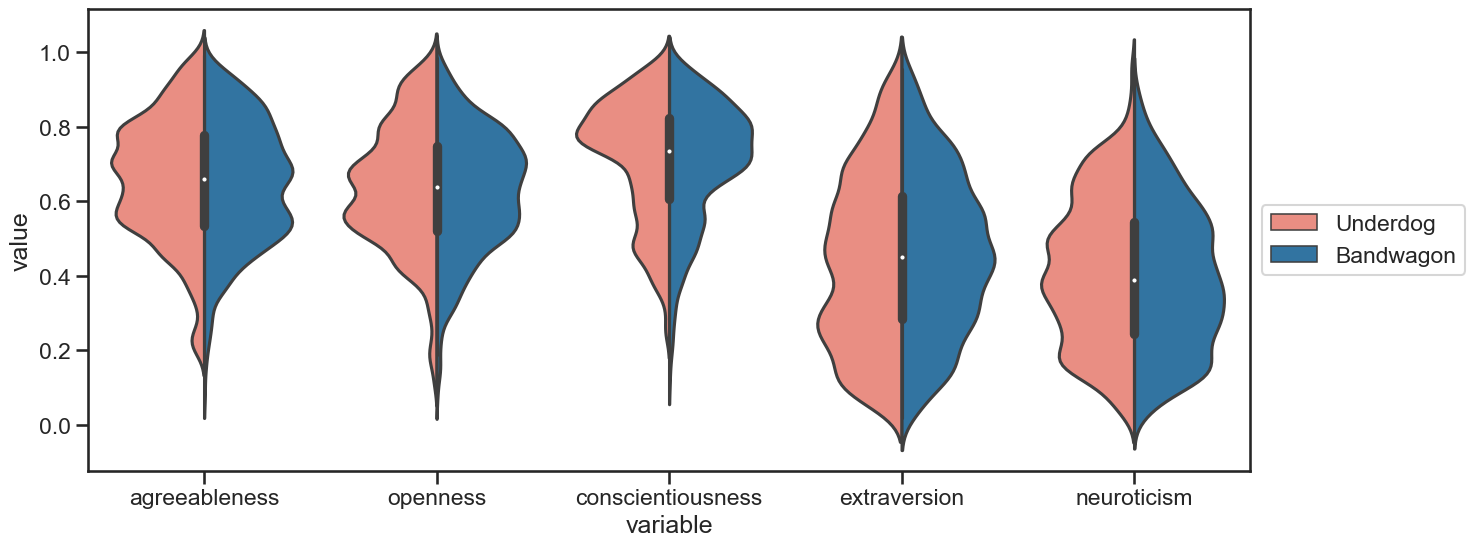

In [45]:
fig, ax = plt.subplots(figsize=(15,6))

g = sns.violinplot(x="variable", y="value", hue="underdog", data=d2, palette=['salmon','#1f77b4'], split=True, bw=.2, ax=ax)

# Put the legend out of the figure
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('images/SI-no-statistical-relationship-between-personality-and-underdog-2.png')
plt.show()

___________________________